# Setup

In [152]:
import glob as gb
from IPython.display import display

import datetime

import pandas as pd
import numpy as np

import math

import pathlib

import sqlite3

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
gb.glob('**/*.sql', recursive=True)

['outputs\\energyplus\\eplusout.sql']

In [3]:
# Directory with datasets:
ROOT_DIR = "files"

In [4]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)
pd.options.display.max_rows = 200

In [5]:
# Define path to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\05_LCA_Repo\outputs\IMG


In [6]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

## Class EnergyPlus SQL

To work with the output data from EnergyPlus:

In [150]:
class EPLusSQL():

    def __init__(self, sql_path=None):
        abs_sql_path = os.path.abspath(sql_path)
        self.sql_uri = '{}?mode=ro'.format(pathlib.Path(abs_sql_path).as_uri())

    def get_annual_energy_by_fuel_and_enduse(self):
        """
        Queries SQL file and returns the ABUPS' End Uses table

        Parameters
        ----------
        None

        Returns
        -------
        df_end_use: pd.DataFrame
            Annual End Use table
            index = 'EndUse'
            columns = ['FuelType','Units']
        """

        # RowName = '#{end_use}'
        # ColumnName='#{fuel_type}'
        annual_end_use_query = """SELECT RowName, ColumnName, Units, Value
            FROM TabularDataWithStrings
            WHERE ReportName='AnnualBuildingUtilityPerformanceSummary'
            AND ReportForString='Entire Facility'
            AND TableName='End Uses'
        """

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df_end_use = pd.read_sql(annual_end_use_query, con=con)

        # Convert Value to Float
        df_end_use['Value'] = pd.to_numeric(df_end_use['Value'])

        df_end_use = df_end_use.set_index(['RowName',
                                           'ColumnName',
                                           'Units'])['Value'].unstack([1, 2])
        df_end_use.index.name = 'EndUse'
        df_end_use.columns.names = ['FuelType', 'Units']

        end_use_order = ['Heating', 'Cooling',
                         'Interior Lighting', 'Exterior Lighting',
                         'Interior Equipment', 'Exterior Equipment',
                         'Fans', 'Pumps', 'Heat Rejection', 'Humidification',
                         'Heat Recovery', 'Water Systems',
                         'Refrigeration', 'Generators']
        col_order = [
            'Electricity', 'Natural Gas', 'Gasoline', 'Diesel', 'Coal',
            'Fuel Oil No 1', 'Fuel Oil No 2', 'Propane', 'Other Fuel 1',
            'Other Fuel 2', 'District Cooling', 'District Heating',
            'Water']
        df_end_use = df_end_use[col_order].loc[end_use_order]

        # Filter out columns with ALL zeroes
        df_end_use = df_end_use.loc[:, (df_end_use > 0).any(axis=0)]

        return df_end_use

    def get_unmet_hours_table(self):
        """
        Queries 'SystemSummary' and returns all unmet hours

        Parameters
        ----------
        None

        Returns
        -------
        df_unmet: pd.DataFrame
            A DataFrame where


        """

        query = """SELECT RowName, ColumnName, Units, Value FROM TabularDataWithStrings
    WHERE ReportName='SystemSummary'
    AND ReportForString='Entire Facility'
    AND TableName='Time Setpoint Not Met'
    """
        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df_unmet = pd.read_sql(query, con=con)

        # Convert Value to Float
        df_unmet['Value'] = pd.to_numeric(df_unmet['Value'])

        df_unmet = df_unmet.pivot(index='RowName',
                                  columns='ColumnName',
                                  values='Value')

        df_unmet.columns.names = ['Time Setpoint Not Met (hr)']

        # Move 'Facility' as last row (Should always be in the index...)
        if 'Facility' in df_unmet.index:
            df_unmet = df_unmet.loc[[x for x
                                     in df_unmet.index
                                     if x != 'Facility'] + ['Facility']]

        return df_unmet

    def get_reporting_vars(self):
        """
        Queries 'ReportingDataDictionary' and returns a DataFrame

        Parameters
        -----------
        None

        Returns
        ---------
        df_vars: pd.DataFrame
            A DataFrame where each row is a reporting variable
        """

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            query = '''
        SELECT KeyValue, Name, TimestepType, ReportingFrequency, Units, Type
            FROM ReportDataDictionary
            '''
            df_vars = pd.read_sql(query, con=con)

        return df_vars

    def get_hourly_variables(self, variables_list):
        """
        Queries Hourly variables which names are in variables_list

        eg: variables_list=['Zone Thermal Comfort CEN 15251 Adaptive Model Temperature']
        """

        query = '''
        SELECT EnvironmentPeriodIndex, Month, Day, Hour, Minute,
            ReportingFrequency, KeyValue, Name, Units,
            Value
        FROM ReportVariableWithTime
        '''

        cond = []

        cond.append(
            ("UPPER(Name) IN ({})".format(', '.join(
                map(repr, [name.upper() for name in variables_list]))))
        )

        cond.append('ReportingFrequency = "Hourly"')

        query += '  WHERE {}'.format('\n    AND '.join(cond))

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df = pd.read_sql(query, con=con)

        df_pivot = pd.pivot_table(df, values='Value',
                                  columns=['ReportingFrequency', 'KeyValue',
                                           'Name', 'Units'],
                                  index=['EnvironmentPeriodIndex',
                                         'Month', 'Day', 'Hour', 'Minute'])

        df_pivot = df_pivot.loc[3]  # Get the annual environment period index

        # We know it's hourly, so recreate a clear index
        (month, day, hour, minute) = df_pivot.index[0]
        start = datetime.datetime(2005, month, day)
        df_pivot.index = pd.date_range(
            start=start, periods=df_pivot.index.size, freq='H')
        df_pivot = df_pivot['Hourly']

        return df_pivot

    def get_timestep_variables(self, variables_list=None):
        """
        Queries 'Zone Timestep' variables which names are in variables_list (if supplied, otherwise all)

        eg: variables_list=['Zone Thermal Comfort CEN 15251 Adaptive Model Temperature']
        """

        query = '''
        SELECT EnvironmentPeriodIndex, Month, Day, Hour, Minute,
            ReportingFrequency, KeyValue, Name, Units,
            Value
        FROM ReportVariableWithTime
        '''

        cond = []

        if variables_list:
            cond.append(
                ("UPPER(Name) IN ({})".format(', '.join(
                    map(repr, [name.upper() for name in variables_list]))))
            )

        cond.append('ReportingFrequency = "Zone Timestep"')

        query += '  WHERE {}'.format('\n    AND '.join(cond))

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df = pd.read_sql(query, con=con)

        df_pivot = pd.pivot_table(df, values='Value',
                                  columns=['ReportingFrequency', 'KeyValue',
                                           'Name', 'Units'],
                                  index=['EnvironmentPeriodIndex',
                                         'Month', 'Day', 'Hour', 'Minute'])

        df_pivot = df_pivot.loc[3]  # Get the annual environment period index

        # We know it's Zone Timestep, with 15min timestep, so recreate a clear index
        (month, day, hour, minute) = df_pivot.index[0]
        start = datetime.datetime(2005, month, day)

        df_pivot.index = pd.date_range(
            start=start, periods=df_pivot.index.size, freq='15Min')
        df_pivot = df_pivot['Zone Timestep']

        return df_pivot

# List of Scenarios with their Parameters

Import the Excel file with the scenarios for the BEM and LCA (i.e., the parameter values for the configuration of the model):

In [8]:
LCA_scenarios = pd.ExcelFile(os.path.join(ROOT_DIR, "LCA_scenarios.xlsx"))

Define a series of dataframes for each step of calculation:

In [9]:
print("LCA_scenarios, sheet names = \n {}\n".format(LCA_scenarios.sheet_names))

LCA_scenarios, sheet names = 
 ['Scenarios', 'Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Step16', 'Step17', 'Step18', 'Step19', 'Step20', 'Step21', 'Step22']



In [10]:
# Create dataframe for with scenarios for each step:
df_step1 = LCA_scenarios.parse('Step1').set_index('name')
df_step2 = LCA_scenarios.parse('Step2').set_index('name')
df_step3 = LCA_scenarios.parse('Step3').set_index('name')
df_step4 = LCA_scenarios.parse('Step4').set_index('name')
df_step5 = LCA_scenarios.parse('Step5').set_index('name')
df_step6 = LCA_scenarios.parse('Step6').set_index('name')
df_step7 = LCA_scenarios.parse('Step7').set_index('name')
df_step8 = LCA_scenarios.parse('Step8').set_index('name')
df_step9 = LCA_scenarios.parse('Step9').set_index('name')
df_step10 = LCA_scenarios.parse('Step10').set_index('name')
df_step11 = LCA_scenarios.parse('Step11').set_index('name')
df_step12 = LCA_scenarios.parse('Step12').set_index('name')
df_step13 = LCA_scenarios.parse('Step13').set_index('name')
df_step14 = LCA_scenarios.parse('Step14').set_index('name')
df_step15 = LCA_scenarios.parse('Step15').set_index('name')
df_step16 = LCA_scenarios.parse('Step16').set_index('name')
df_step17 = LCA_scenarios.parse('Step17').set_index('name')
df_step18 = LCA_scenarios.parse('Step18').set_index('name')
df_step19 = LCA_scenarios.parse('Step19').set_index('name')
df_step20 = LCA_scenarios.parse('Step20').set_index('name')
df_step21 = LCA_scenarios.parse('Step21').set_index('name')
df_step22 = LCA_scenarios.parse('Step22').set_index('name')

# Building Energy Simulation with EnergyPlus

Inspired by the notebooks on Data Driven Building posted on GitHub by Clayton Miller:
https://github.com/buds-lab/python-for-building-analysts

## Setup for the Energy Simulation

In [11]:
from eppy import modeleditor
from eppy.modeleditor import IDF

iddfile = "C:\EnergyPlusV9-5-0\Energy+.idd"
IDF.setiddname(iddfile)

In [12]:
ROOT_DIR_EPlus = "files\EnergyPlus"

# Weather data for Brussels:
epwfile = os.path.join(ROOT_DIR_EPlus, "BEL_Brussels.064510_IWEC.epw")

# IDF file, initial configuration:
idfname_init = os.path.join(ROOT_DIR_EPlus, "BEM_init.idf")
# Same configuration, with overhangs:
idfname_overhangs = os.path.join(ROOT_DIR_EPlus, "BEM_overhangs.idf")

# IDF file, HVAC changed, optimised VAV system:
idfname_vav = os.path.join(ROOT_DIR_EPlus, "BEM_VAV_optimised.idf")
# Same configuration, with overhangs:
idfname_vav_overhangs = os.path.join(ROOT_DIR_EPlus,
                                     "BEM_VAV_optimised_overhangs.idf")

# IDF file, HVAC changed, VRF system:
idfname_vrf = os.path.join(ROOT_DIR_EPlus, "BEM_VRF.idf")
# Same configuration, with overhangs:
idfname_vrf_overhangs = os.path.join(ROOT_DIR_EPlus,
                                     "BEM_VRF_overhangs.idf")

# IDF file for smart glass modeling, initial configuration:
idfname_smartglass = os.path.join(ROOT_DIR_EPlus, "BEM_SmartGlass.idf")

In [13]:
# Setup of the IDF_init:
idf_init = IDF(idfname_init, epwfile)

In [14]:
# look at a specific object:
building = idf_init.idfobjects['BUILDING'][0]
building


Building,
    Office,                   !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

In [15]:
# Change a parameter:
building.Name = "Fully-glazed office building"
building.Name

'Fully-glazed office building'

## Materials and Construction

Materials:

In [16]:
materials = idf_init.idfobjects["Material"]
print(materials)

[
Material,
    F13 Built-up roofing,     !- Name
    Rough,                    !- Roughness
    0.0095,                   !- Thickness
    0.16,                     !- Conductivity
    1120,                     !- Density
    1460,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.7,                      !- Solar Absorptance
    0.7;                      !- Visible Absorptance
, 
Material,
    Gypsum_13mm,              !- Name
    Smooth,                   !- Roughness
    0.0127,                   !- Thickness
    0.16,                     !- Conductivity
    800,                      !- Density
    1090,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.7,                      !- Solar Absorptance
    0.5;                      !- Visible Absorptance
, 
Material,
    METAL Door Medium 18Ga_1,    !- Name
    Smooth,                   !- Roughness
    0.0013106,                !- Thickness
    4

In [17]:
# Glazing types:
igus = idf_init.idfobjects["WindowMaterial:SimpleGlazingSystem"]
print(igus)

[
WindowMaterial:SimpleGlazingSystem,
    ccf,                      !- Name
    0.75,                     !- UFactor
    0.2,                      !- Solar Heat Gain Coefficient
    0.44;                     !- Visible Transmittance
, 
WindowMaterial:SimpleGlazingSystem,
    DG_0_clear,               !- Name
    2.71,                     !- UFactor
    0.69,                     !- Solar Heat Gain Coefficient
    0.77;                     !- Visible Transmittance
, 
WindowMaterial:SimpleGlazingSystem,
    DG_1_highSHG_highLT,      !- Name
    1.1,                      !- UFactor
    0.62,                     !- Solar Heat Gain Coefficient
    0.82;                     !- Visible Transmittance
, 
WindowMaterial:SimpleGlazingSystem,
    DG_2_midSHG_midLT,        !- Name
    1,                        !- UFactor
    0.41,                     !- Solar Heat Gain Coefficient
    0.58;                     !- Visible Transmittance
, 
WindowMaterial:SimpleGlazingSystem,
    DG_3_midSHG_highLT,   

In [18]:
# Exterior shading and thermal curtain:
shades = idf_init.idfobjects["WindowMaterial:Shade"]
print(shades)

[
WindowMaterial:Shade,
    Ext_EnviroScreen_lightgrey_silver,    !- Name
    0.05,                     !- Solar Transmittance
    0.74,                     !- Solar Reflectance
    0.04,                     !- Visible Transmittance
    0.9,                      !- Visible Reflectance
    0.9,                      !- Infrared Hemispherical Emissivity
    0,                        !- Infrared Transmittance
    0.0005,                   !- Thickness
    0.15,                     !- Conductivity
    0.05,                     !- Shade to Glass Distance
    0,                        !- Top Opening Multiplier
    0,                        !- Bottom Opening Multiplier
    0,                        !- LeftSide Opening Multiplier
    0,                        !- RightSide Opening Multiplier
    0.1;                      !- Airflow Permeability
, 
WindowMaterial:Shade,
    Int_Isotiss_Thermal Curtain and Air Wall,    !- Name
    0.12,                     !- Solar Transmittance
    0.71,         

Constructions:

In [19]:
constructions = idf_init.idfobjects["CONSTRUCTION"]
print(constructions)

[
Construction,
    ccf,                      !- Name
    ccf;                      !- Outside Layer
, 
Construction,
    dg_0_clear,               !- Name
    DG_0_clear;               !- Outside Layer
, 
Construction,
    dg_1_highSHG_highLT,      !- Name
    DG_1_highSHG_highLT;      !- Outside Layer
, 
Construction,
    dg_2_midSHG_midLT,        !- Name
    DG_2_midSHG_midLT;        !- Outside Layer
, 
Construction,
    dg_3_midSHG_highLT,       !- Name
    DG_3_midSHG_highLT;       !- Outside Layer
, 
Construction,
    dg_4_lowSHG_lowLT,        !- Name
    DG_4_lowSHG_lowLT;        !- Outside Layer
, 
Construction,
    dg_5k_Krypton_lowSHG_midLT,    !- Name
    DG_5_Krypton_lowSHG_midLT;    !- Outside Layer
, 
Construction,
    dg_5_lowSHG_midLT,        !- Name
    DG_5_lowSHG_midLT;        !- Outside Layer
, 
Construction,
    dg_6_lowSHG_highLT,       !- Name
    DG_6_lowSHG_highLT;       !- Outside Layer
, 
Construction,
    dg_init_bronze,           !- Name
    DG_init_bronze;

In [20]:
len(constructions)

32

In [21]:
[construction.Name for construction in constructions]

['ccf',
 'dg_0_clear',
 'dg_1_highSHG_highLT',
 'dg_2_midSHG_midLT',
 'dg_3_midSHG_highLT',
 'dg_4_lowSHG_lowLT',
 'dg_5k_Krypton_lowSHG_midLT',
 'dg_5_lowSHG_midLT',
 'dg_6_lowSHG_highLT',
 'dg_init_bronze',
 'dg_vacuum',
 'sg_1_clear',
 'sg_2_coated',
 'tg_1_highSHG_highLT',
 'tg_2_midSHG_midLT',
 'tg_3_midSHG_highLT',
 'tg_4_lowSHG_lowLT',
 'tg_5k_Krypton_lowSHG_midLT',
 'tg_5x_Xenon_lowSHG_midLT',
 'tg_5_lowSHG_midLT',
 'tg_6_lowSHG_highLT',
 '_ConcreteAndCarpet',
 '_ConcreteAndCarpet Reversed',
 '_ConcreteSlab_200mm',
 '_Concrete_300mm',
 '_Door_Metal',
 '_DropCeiling',
 '_ExtDoor_Main entrance',
 '_Gypsum13_Concrete200mm_Gypsum13',
 '_Roof',
 '_Spandrel_Equivalent',
 '_WoodFurnitures']

Total area of conditioned indoor climate or glazed façade:

In [22]:
net_conditioned_area = 8100
glazed_facade_area = 2340

Listing the different types of IGUs according to the efficiency of their frame:

In [23]:
igu_low_perf = ['dg_init_bronze', 'dg_0_clear', 'sg_1_clear', 'sg_2_coated']
igu_high_perf = ['dg_1_highSHG_highLT', 'dg_2_midSHG_midLT',
                 'dg_3_midSHG_highLT', 'dg_4_lowSHG_lowLT',
                 'dg_5_lowSHG_midLT', 'dg_6_lowSHG_highLT',
                 'dg_5k_Krypton_lowSHG_midLT', 'dg_vacuum',
                 'tg_1_highSHG_highLT', 'tg_2_midSHG_midLT',
                 'tg_3_midSHG_highLT', 'tg_4_lowSHG_lowLT',
                 'tg_5_lowSHG_midLT', 'tg_6_lowSHG_highLT',
                 'tg_5k_Krypton_lowSHG_midLT', 'tg_5x_Xenon_lowSHG_midLT',
                 'ccf'
                 ]

## Functions to Conduct Simulations

Function to modify idf according to scenario parameters:

In [24]:
def modify_idf(idfname_init, epwfile, igu, run_n, df_step):
    """
    Modify the idf parameters, i.e. glazing, frame, and shadings, 
    according to the parameters defined in the dataframe,
    and returns the idf file

    Parameters
    ----------
    idfname_init: idf file to modify
    epwfile: weather data, .epw
    igu: name of the igu studied for energy simulation
    run_n: name/code for the energy simulation
    df_step: dataframe w/ a list of variables according to which are changed
        the idf parameters

    Returns
    -------
    idf_modified: a copy (saved as) of the initial idf
    """

    idf = IDF(idfname_init, epwfile)
    constructions = idf.idfobjects["CONSTRUCTION"]

    # Change the glazing and frame:
    for element in idf.idfobjects['FenestrationSurface:Detailed']:
        if element.Surface_Type == 'Window':

            # Replace the glazing:
            element.Construction_Name = igu
            if igu not in [construction.Name for construction in constructions]:
                print('Wrong construction name!! See:', igu)

    # Replace the frame:
    for element in idf.idfobjects['WindowProperty:FrameAndDivider']:
        if igu in igu_low_perf:
            if df_step.loc[df_step.index == run_n, 'thermal_curtain'][0] == 0:
                element.Frame_Conductance = 5.5
                element.Divider_Conductance = 5.5
            else:
                element.Frame_Conductance = 1.56
                element.Divider_Conductance = 1.56

        if igu in igu_high_perf:
            if df_step.loc[df_step.index == run_n, 'thermal_curtain'][0] == 0:
                element.Frame_Conductance = 1.5
                element.Divider_Conductance = 1.5
            else:
                element.Frame_Conductance = 1
                element.Divider_Conductance = 1

    # Activate or not the shading control:
    for element in idf.idfobjects['WindowShadingControl']:
        if df_step.loc[df_step.index == run_n, 'thermal_curtain'][0] == 1:
            element.Shading_Type = 'InteriorShade'
            element.Shading_Control_Type = 'OnNightIfLowOutdoorTempAndOffDay'
            element.Schedule_Name = 'Thermal curtain_On'
            element.Setpoint = '19'
            element.Shading_Control_Is_Scheduled = 'Yes'
            element.Glare_Control_Is_Active = 'No'
            element.Shading_Device_Material_Name = 'Int_Isotiss_Thermal Curtain and Air Wall'
            element.Type_of_Slat_Angle_Control_for_Blinds = 'FixedSlatAngle'

        elif df_step.loc[df_step.index == run_n, 'shdg_device'][0] == 1:
            element.Shading_Type = 'ExteriorShade'
            element.Shading_Control_Type = 'OnIfHighZoneAirTempAndHighSolarOnWindow'
            element.Schedule_Name = 'EXT_Shading_On'
            element.Setpoint = '22'
            element.Setpoint_2 = '250'
            element.Shading_Control_Is_Scheduled = 'Yes'
            element.Glare_Control_Is_Active = 'No'
            element.Shading_Device_Material_Name = 'Ext_EnviroScreen_lightgrey_silver'
            element.Type_of_Slat_Angle_Control_for_Blinds = 'FixedSlatAngle'

        else:
            element.Schedule_Name = 'EXT_Shading_OFF'

    # Define heating and cooling setpoint:
    for element in idf.idfobjects['ThermostatSetpoint:DualSetpoint']:
        if ('Core' in element.Name
                or 'Perimeter' in element.Name):
            element.Heating_Setpoint_Temperature_Schedule_Name = (
                df_step.loc[df_step.index == run_n, 'heating_setpoint'][0])
            element.Cooling_Setpoint_Temperature_Schedule_Name = (
                df_step.loc[df_step.index == run_n, 'cooling_setpoint'][0])

    idf.saveas("files\EnergyPlus\copies\BEM_"+str(run_n)+".idf")
    idf_modified = IDF("files\EnergyPlus\copies\BEM_"+str(run_n)+".idf",
                       epwfile)

    print("Saved: BEM_"+str(run_n))

    return idf_modified

In [25]:
# Initialisation of a list for unmet hours during occupied cooling/heating:
ls_unmet = []
# Define an empty DataFrame to save the energy consumption
# per end use for each simulation:
df_end_use_allsteps = pd.DataFrame()

A function to post-process the results and save them in specific DataFrames:

In [26]:
def simulation_postprocess(run_n, df_step, ls_unmet,
                           df_end_use_allsteps):
    """
    Run a simulation from an idf, extract results in df or ls:
    > total energy end use in df_end_use (electricity + natural gas)
    > unmethours during occupation in ls_unmet
    > Energy consumption per enduse in df_end_use_allsteps

    Save also the hourly reporting variables per simulation run 
    in a csv file: df_h_run.csv.

    Parameters
    ----------
    run_n: name/code for the energy simulation
    df_step: df define for each step of the LCA where to save
        values for electricity and natural gas use.
    ls_unmet: list for unmet hours during occupation
    df_end_use_allsteps: DataFrame to save energy consumption per year 
        for the whole facility per end use for every runs

    Returns
    -------
    df_step
    ls_unmet
    df_end_use_allsteps

    """

    # Find the output data:
    eplus_sql = EPLusSQL(sql_path='outputs\energyplus\eplusout.sql')

    # Get total energy end use in a dataframe:
    df_end_use = eplus_sql.get_annual_energy_by_fuel_and_enduse()
    if 'Water' in df_end_use.columns:
        df_end_use = df_end_use.drop('Water', axis=1)
    df_end_use = df_end_use.drop([
        'Exterior Lighting', 'Exterior Equipment', 'Generators',
        'Water Systems', 'Heat Recovery', 'Humidification', 'Refrigeration'])

    # Save total elec and nat gas use for LCA in df_step:
    # Sum of the electricity uses:
    elec_tot_gj = df_end_use[('Electricity', 'GJ')].sum()
    # Convert GJ to kWh:
    elec_tot_kwh = elec_tot_gj * 277.8

    # Use of natural gas:
    if 'Natural Gas' not in df_end_use.columns:
        df_end_use[('Natural Gas', 'GJ')] = 0

    # Use of natural gas:
    gas_tot_gj = df_end_use[('Natural Gas', 'GJ')].sum()
    # Convert GJ to MJ:
    gas_tot_mj = gas_tot_gj * 1000

    # Save values in df_step:
    df_step.loc[df_step.index == run_n, 'elec_use'] = (
        elec_tot_kwh / glazed_facade_area)
    df_step.loc[df_step.index == run_n, 'natural_gas'] = (
        gas_tot_mj/glazed_facade_area)

    # Append the list of unmet hours during occupied cooling/heating:
    df_unmet = eplus_sql.get_unmet_hours_table()
    val_toadd = {'Run': run_n,
                 'During cooling': df_unmet.loc[df_unmet.index == 'Facility',
                                                'During Occupied Cooling'][0],
                 'During heating': df_unmet.loc[df_unmet.index == 'Facility',
                                                'During Occupied Heating'][0]
                 }
    # Avoid duplicating values:
    if len(ls_unmet) > 0:
        for i in range(len(ls_unmet)):
            if ls_unmet[i]['Run'] == val_toadd['Run']:
                # Replace old value:
                ls_unmet[i] = val_toadd
    else:
        # And append if did not exist before:
        ls_unmet.append(val_toadd)

    # Save energy consumption per end use:
    df_end_use = df_end_use.stack(['FuelType'])
    df_end_use['Run name'] = run_n
    df_end_use = df_end_use.reset_index().pivot(
        index='EndUse', columns=['Run name', 'FuelType'], values='GJ')
    if not df_end_use_allsteps.empty:
        # Columns to avoid when merging, avoid duplicates and save new values:
        cols_to_use = df_end_use_allsteps.columns.difference(
            df_end_use.columns)
        # Merge by columns_to_use:
        df_end_use_allsteps = pd.merge(df_end_use,
                                       df_end_use_allsteps[cols_to_use],
                                       on="EndUse")
    else:
        df_end_use_allsteps = df_end_use

    df_end_use_allsteps = df_end_use_allsteps.reindex(sorted(
        df_end_use_allsteps.columns), axis=1)

    # Hourly reporting variables
    # Define an empty DataFrame to save the hourly reporting variables:
    df_h_run = pd.DataFrame()

    ls_vars = [
        'Zone Windows Total Heat Gain Energy',
        'Zone Windows Total Heat Loss Energy',
        'Surface Shading Device Is On Time Fraction',
        'Zone Operative Temperature',
        'Zone Thermal Comfort CEN 15251 Adaptive Model Temperature',
        'Zone Thermal Comfort ASHRAE 55 Adaptive Model Temperature',
        'Chiller Electricity Energy', 'Boiler Heating Energy'
    ]

    df_h_run = eplus_sql.get_hourly_variables(variables_list=ls_vars)

    for col in df_h_run.columns:
        if "BASEMENT" in col[0]:
            df_h_run = df_h_run.drop(col, axis=1)

    # Save df_h_run to csv:
    df_h_run.to_csv('outputs\steps_dir\df_h_run_'+str(run_n[:3])+'.csv',
                    index=True)
    print("df_h_run.csv saved")

    return df_step, ls_unmet, df_end_use_allsteps

**Units:**
- Data saved in df_end_use_allsteps in GJ;
- Data saved in df_steps in kWh (electricity) and MJ (natural gas) per m² of glazed area.

A function to save the results in csv files:

In [27]:
def save_results_csv(n_step, df_step, ls_unmet, df_end_use_allsteps):
    """
    Save the DataFrames and Lists where the results are to avoid 
    reruning the time consuming energy simulation

    Parameters
    ----------
    n_step: number of the step
    df_step: df define for each step of the LCA where to save
        values for electricity and natural gas use.
    ls_unmet: list for unmet hours during occupation
    df_end_use_allsteps: dataframe with end uses 
        per type of energy per simulation run

    Returns
    -------
    None

    """

    # Save df_step to csv:
    df_step.to_csv('outputs\steps_dir\df_step'+str(n_step)+'.csv', index=True)
    print("df_step.csv saved")

    # Save ls_unmet to csv:
    df_ls_unmet = pd.DataFrame(ls_unmet)
    df_ls_unmet.to_csv('outputs\steps_dir\df_ls_unmet.csv', index=False)
    print("ls_unmet.csv saved")

    # Save df_end_use_allsteps to csv:
    df_end_use_allsteps.stack([0, 1]).to_csv(
        'outputs\steps_dir\df_end_use_allsteps.csv', index=True)
    print("df_end_use_allsteps.csv saved")
    print("------")

    return

## Save idf Files

## Simulation Runs

<font color='red'>To run all the simulations or not:<font>

In [28]:
run_all = False

### Recover data saved in csv files from previous simulations:

To read directly the csv file and work from them instead of relaunching the energy simulation (Please note that this does not prevent the simulations from being run again. To do this, change the run_all boolean variable above. If the simulations are rerun, the new results will overwrite the old ones saved in the csv files):

Dataframe with all energy usage data per simulation run:

Retrieve the data from the csv. The simulation_postprocess function will merge the new results by overwriting the old ones, or simply add the new ones if they did not exist yet.

In [29]:
# Open the df_end_use_allsteps from the csv file:
# Avoid re-running energy simulations (time consuming):
if os.path.isfile('outputs\steps_dir\df_end_use_allsteps.csv'):
    df_end_use_allsteps_csv = (
        pd.read_csv('outputs\steps_dir\df_end_use_allsteps.csv'))
    df_end_use_allsteps_csv = df_end_use_allsteps_csv.pivot_table(
        values='0', index=['EndUse'], columns=['Run name', 'FuelType'])

    df_end_use_allsteps = df_end_use_allsteps_csv

List of dict with unmet hours per simulation run during heating and cooling:

Retrieve the data from the csv. The simulation_postprocess function will add the new results and eventualy overwrite the old ones, if they exist. 

In [30]:
if os.path.isfile('outputs\steps_dir\df_ls_unmet.csv'):
    # Open the df_ls_unmet from the csv file created after energy simulation:
    df_ls_unmet_csv = pd.read_csv('outputs\steps_dir\df_ls_unmet.csv')
    # Convert back to a list of dict:
    ls_unmet_csv = df_ls_unmet_csv.to_dict('records')

Dataframe with the main assumptions and results (natural gas and electricity) specific to each simulation run:

A function to recover df_step dataframes saved as csv:

In [31]:
def recover_df_step(n_step, df_step):
    """
    If a df_step.csv exists, recover it as a dataframe wich replace 
    the one currently in use in the notebook.
    Avoid re-running energy simulation (time consuming).

    Parameters
    ----------
    n_step: number of the step
    df_step: a dataframe. followed by a number (e.g. step4), 
    identify the step with simulation runs and main results

    Returns
    -------
    df_step: update with csv data or exactly the same as the one in the input

    """

    # Does the csv exist
    # and check if the existing df_step includes simulation results:
    if (os.path.isfile(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            and np.isnan(
                sum(df_step["natural_gas"]) + sum(df_step["elec_use"]))):
        df_step = (
            pd.read_csv(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            .set_index(['name']))

        print("df_step updated with csv data")
    else:
        print("existing df_step kept in place")

    return df_step

### Step 1-3: Initial Configuration with Different Glazing Types

**Step 1: Different glazing types, w/o shading devices and thermal curtain, fan coil chiller w/ boiler**

Run the simulations (it takes time! Be patient):

In [32]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step1.index:
        # Note the glazing type:
        igu = df_step1['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_init, epwfile, igu, run_n, df_step1)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step1, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step1, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(1, df_step1, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [33]:
df_step1 = recover_df_step(1, df_step1)

df_step updated with csv data


**Step 2: Different glazing types, with shading devices, fan coil chiller w/ boiler**

In [34]:
# Overview of the step_2 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step2)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
b_a_2126_dg_init_sd,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_b_2126_dg0_sd,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_c_2126_sg1_sd,sg_1_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_d_2126_sg2_sd,sg_2_coated,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_e_2126_dg1_sd,dg_1_highSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_f_2126_dg2_sd,dg_3_midSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_g_2126_dg3_sd,dg_2_midSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_h_2126_dg4_sd,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_i_2126_dg5_sd,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


Run the simulations (it takes time! Be patient):

In [35]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step2.index:
        # Note the glazing type:
        igu = df_step2['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_init, epwfile, igu, run_n, df_step2)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step2, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step2, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(2, df_step2, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [36]:
df_step2 = recover_df_step(2, df_step2)

df_step updated with csv data


**Step 2: Different glazing types, with overhangs and thermal curtains, fan coil chiller w/ boiler**

Run the simulations (it takes time! Be patient):

In [37]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step3.index:
        # Note the glazing type:
        igu = df_step3['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_overhangs, epwfile,
                                  igu, run_n, df_step3)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step3, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step3, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(3, df_step3, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [38]:
df_step3 = recover_df_step(3, df_step3)

df_step updated with csv data


### Steps 4-5: HVAC System optimisation, with VAV

- Step 4:
HVAC is an efficient VAV system. Include exterior shading. Cooling setpoint 26°C, heating setpoint 21°C.
- Step 15:
HVAC is an efficient VAV system. Include overhangs and thermal curtains. Cooling setpoint 26°C, heating setpoint 21°C.

In [39]:
# Overview of the step_4 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step4)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
d_a_2126_dg_init_vav_sd,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_b_2126_dg0_vav_sd,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_c_2126_sg1_vav_sd,sg_1_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_d_2126_sg2_vav_sd,sg_2_coated,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_e_2126_dg1_vav_sd,dg_1_highSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_f_2126_dg2_vav_sd,dg_3_midSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_g_2126_dg3_vav_sd,dg_2_midSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_h_2126_dg4_vav_sd,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_i_2126_dg5_vav_sd,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


In [40]:
# Overview of the step_5 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step5)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
e_a_2126_dg_init_vav_tc,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_b_2126_dg0_vav_tc,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_c_2126_sg1_vav_tc,sg_1_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_d_2126_sg2_vav_tc,sg_2_coated,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_e_2126_dg1_vav_tc,dg_1_highSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_f_2126_dg2_vav_tc,dg_3_midSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_g_2126_dg3_vav_tc,dg_2_midSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_h_2126_dg4_vav_tc,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_i_2126_dg5_vav_tc,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


**Step 4: HVAC is an efficient VAV system. Exterior shading. Cooling setpoint 26°C, heating setpoint 21°C**

Run the simulations (it takes time! Be patient):

In [41]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step4.index:
        # Note the glazing type:
        igu = df_step4['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step4)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step4, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step4, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(4, df_step4, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [42]:
df_step4 = recover_df_step(4, df_step4)

df_step updated with csv data


**Step 5: HVAC is an efficient VAV system. Overhangs, thermal curtains. Cooling setpoint 26°C, heating setpoint 21°C**

Run the simulations (it takes time! Be patient):

In [43]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step5.index:
        # Note the glazing type:
        igu = df_step5['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav_overhangs, epwfile,
                                  igu, run_n, df_step5)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step5, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step5, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(5, df_step5, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [44]:
df_step5 = recover_df_step(5, df_step5)

df_step updated with csv data


### Steps 6-7: HVAC System optimisation, with VRF

- Step 6:
HVAC is an efficient VRF system. Include exterior shading. Cooling setpoint 26°C, heating setpoint 21°C.
- Step 7:
HVAC is an efficient VRF system. Include overhangs and thermal curtains. Cooling setpoint 26°C, heating setpoint 21°C.

Now, energy simulation with VRF system.

**Step 6: HVAC is an efficient VRF system. Exterior shading. Cooling setpoint 26°C, heating setpoint 19°C**

Run the simulations (it takes time! Be patient):

In [45]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step6.index:
        # Note the glazing type:
        igu = df_step6['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vrf, epwfile,
                                  igu, run_n, df_step6)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step6, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step6, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(6, df_step6, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [46]:
df_step6 = recover_df_step(6, df_step6)

df_step updated with csv data


**Step 7: HVAC is an efficient VRF system. Overhangs and thermal curtains. Cooling setpoint 27°C, heating setpoint 18°C**

Run the simulations (it takes time! Be patient):

In [47]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step7.index:
        # Note the glazing type:
        igu = df_step7['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vrf_overhangs, epwfile,
                                  igu, run_n, df_step7)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step7, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step7, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(7, df_step7, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [48]:
df_step7 = recover_df_step(7, df_step7)

df_step updated with csv data


### Step 8: Reduction of the Window-to-Wall Ratio

Run the simulations (it takes time! Be patient):

In [49]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step8.index:
        # Note the glazing type:
        igu = df_step8['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step8)

        # Modify the window-to-wall ratio (75% of the existing one):
        for element in idf_modified.idfobjects['FenestrationSurface:Detailed']:
            if element.Surface_Type == 'Window':
                if "Ground" in element.Name:
                    # Reduce the height of the ground floor windows:
                    element.Vertex_2_Zcoordinate += 0.70
                    element.Vertex_3_Zcoordinate += 0.70
                else:
                    # Reduce the height of the mid/top floor windows:
                    element.Vertex_2_Zcoordinate += 0.60
                    element.Vertex_3_Zcoordinate += 0.60

        idf_modified.save()

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step8, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step8, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(8, df_step8, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [50]:
df_step8 = recover_df_step(8, df_step8)

df_step updated with csv data


### Steps 9-15: high-tech retrofitting, from krypton to smart glass

- Steps:
9. Double glazing filled w/ krypton
10. Triple glazing filled w/ krypton	 
11. Triple glazing filled w/ xenon 
12. Closed Cavity Facade	(CCF)
13. Vaccum glazing	
14. Smart double glazing
15. Double Skin Facade (DSF)

**Step 9: Double glazing filled w/ krypton**

In [51]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step9.index:
        # Note the glazing type:
        igu = df_step9['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step9)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step9, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step9, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(9, df_step9, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [52]:
df_step9 = recover_df_step(9, df_step9)

df_step updated with csv data


**Step 10: Triple glazing filled w/ krypton**

In [53]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step10.index:
        # Note the glazing type:
        igu = df_step10['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step10)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step10, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step10, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(10, df_step10, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [54]:
df_step10 = recover_df_step(10, df_step10)

df_step updated with csv data


**Step 11: Triple glazing filled w/ xenon**

In [55]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step11.index:
        # Note the glazing type:
        igu = df_step11['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step11)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step11, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step11, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(11, df_step11, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [56]:
df_step11 = recover_df_step(11, df_step11)

df_step updated with csv data


**Step 12: Closed cavity facade**

In [57]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step12.index:
        # Note the glazing type:
        igu = df_step12['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step12)

        # CCF use in between shading:
        for element in idf_modified.idfobjects['WindowShadingControl']:
            element.Shading_Type = 'ExteriorShade'
            element.Shading_Control_Type = 'OnIfHighZoneAirTempAndHighSolarOnWindow'
            element.Schedule_Name = 'EXT_Shading_On'
            element.Setpoint = '22'
            element.Setpoint_2 = '250'
            element.Shading_Control_Is_Scheduled = 'Yes'
            element.Glare_Control_Is_Active = 'No'
            element.Shading_Device_Material_Name = 'Ext_EnviroScreen_lightgrey_silver'
            element.Type_of_Slat_Angle_Control_for_Blinds = 'FixedSlatAngle'

        idf_modified.save()

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step12, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step12, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(12, df_step12, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [58]:
df_step12 = recover_df_step(12, df_step12)

df_step updated with csv data


**Step 13: Vaccum glazing**

In [59]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step13.index:
        # Note the glazing type:
        igu = df_step13['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step13)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step13, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step13, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(13, df_step13, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [60]:
df_step13 = recover_df_step(13, df_step13)

df_step updated with csv data


**Step 10: Smart double glazing**

In [61]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step14.index:
        # Note the glazing type:
        igu = df_step14['glazing'][run_n]

        # Run the energy simulation:
        idf_smartglass = IDF(idfname_smartglass, epwfile)
        idf_smartglass.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step14, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step14, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(14, df_step14, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [62]:
df_step14 = recover_df_step(14, df_step14)

df_step updated with csv data


**Step 15: Double Skin Facade (DSF)**

The analysis of the double skin facade system is not based on energy modelling, but on the results of a review conducted by Pomponi et al. on more than 50 publications.

See: Pomponi et al., 2016. "Energy performance of Double-Skin Façades in temperate climates: A systematic review and meta-analysis," *Renewable and Sustainable Energy Reviews*.

The authors summarise the results in terms of possible energy use reduction.
The average reduction in heating load is 33%, but with a high degree of variability. Taking into account the 75th and 25th percentiles, the maximum reduction is about 50% and the minimum about 20%.
The average reduction of the cooling load is 28%, with slightly less variability than in the case of the heating load. Taking into account the 75th and 25th percentiles, the maximum reduction is 40% and the minimum 20%.

These values are applied to the average energy use for double and triple glazing with exterior shading device (step4), VAV optimised.

In [63]:
if run_all:

    df_copy = df_end_use_allsteps[[
        "d_e_2126_dg1_vav_sd", "d_f_2126_dg2_vav_sd", "d_g_2126_dg3_vav_sd",
        "d_h_2126_dg4_vav_sd", "d_i_2126_dg5_vav_sd", "d_j_2126_dg6_vav_sd",
        "d_k_2126_tg1_vav_sd", "d_l_2126_tg2_vav_sd", "d_m_2126_tg3_vav_sd",
        "d_n_2126_tg4_vav_sd", "d_o_2126_tg5_vav_sd", "d_p_2126_tg6_vav_sd"]
    ].copy()

    df_step4_mean = df_copy.groupby(level=1, axis=1).mean()
    df_step4_mean.columns = pd.MultiIndex.from_product([['mean'],
                                                        df_step4_mean.columns])

    df_end_use_allsteps = df_end_use_allsteps.stack()
    df_step4_mean = df_step4_mean.stack()

    for name in df_step15.index:
        df_end_use_allsteps[name] = df_step4_mean["mean"]
        print(name)

    df_end_use_allsteps = df_end_use_allsteps.unstack()
    df_step4_mean = df_step4_mean.unstack()

    for name in df_step15.index:
        for energy in ["Natural Gas", "Electricity"]:
            if "min" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.50)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)].loc["Cooling"]*0.60)
            if "mean" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.77)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)]["Cooling"]*0.72)
            if "mean" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.80)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)]["Cooling"]*0.80)

In [64]:
if run_all:

    # Update df_step15 with natural gas and electricity use:
    for name in df_step15.index:
        # Sum of the electricity uses:
        elec_tot_gj = df_end_use_allsteps[(name, 'Electricity')].sum()
        # Convert GJ to kWh:
        elec_tot_kwh = elec_tot_gj * 277.8
        # Use of natural gas:
        gas_tot_gj = df_end_use_allsteps[(name, 'Natural Gas')].sum()
        # Convert GJ to MJ:
        gas_tot_mj = gas_tot_gj * 1000

        # Save values in df_step15, per m² of glazed facade:
        df_step15.loc[df_step15.index == name, 'elec_use'] = (
            elec_tot_kwh / glazed_facade_area)
        df_step15.loc[df_step15.index == name, 'natural_gas'] = (
            gas_tot_mj/glazed_facade_area)

    # Save results:
    save_results_csv(15, df_step15, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [65]:
df_step15 = recover_df_step(15, df_step15)

df_step updated with csv data


### Step 16: Americanisation of the interior climate

- Cooling setpoint: 24°C
- Heating setpoint: 21°C
- With exterior shadings

In [66]:
# Overview of the step_16 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step16)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
p_a_2124_dg_init_sd,dg_init_bronze,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
p_b_2124_dg0_sd,dg_0_clear,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
p_c_2124_dg4_sd,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
p_d_2124_dg5_sd,dg_5_lowSHG_midLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
p_e_2124_dg6_sd,dg_6_lowSHG_highLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
p_f_2124_tg4_sd,tg_4_lowSHG_lowLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
p_g_2124_tg5_sd,tg_5_lowSHG_midLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
p_h_2124_tg6_sd,tg_6_lowSHG_highLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0


Run the simulations (it takes time! Be patient):

In [67]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step16.index:
        # Note the glazing type:
        igu = df_step16['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step16)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step16, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step16, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(16, df_step16, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [68]:
df_step16 = recover_df_step(16, df_step16)

df_step updated with csv data


### Step 17: sufficiency path

- Cooling setpoint: 18°C
- Heating setpoint: 27°C
- With overhangs and thermal curtains

In [69]:
# Overview of the step_17 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step17)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
q_a_1927_dg_init_tc,dg_init_bronze,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
q_b_1927_dg0_tc,dg_0_clear,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
q_c_1927_dg4_tc,dg_4_lowSHG_lowLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
q_d_1927_dg5_tc,dg_5_lowSHG_midLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
q_e_1927_dg6_tc,dg_6_lowSHG_highLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
q_f_1927_tg4_tc,tg_4_lowSHG_lowLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
q_g_1927_tg5_tc,tg_5_lowSHG_midLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
q_h_1927_tg6_tc,tg_6_lowSHG_highLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0


Run the simulations (it takes time! Be patient):

In [70]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step17.index:
        # Note the glazing type:
        igu = df_step17['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav_overhangs, epwfile,
                                  igu, run_n, df_step17)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step17, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step17, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(17, df_step17, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [71]:
df_step17 = recover_df_step(17, df_step17)

df_step updated with csv data


### Steps 18-19: internal gains

- Step 18: Increase of the internal gains. Density of 6.5 m²/p. instead of 10m²/p; lighting power of 10 W/m² instead of 8 W/m².

In [72]:
# Overview of the step_18 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step18)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
r_a_2126_dg_init_intgain,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
r_b_2126_dg0_intgain,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
r_c_2126_dg4_intgain,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
r_d_2126_dg5_intgain,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
r_e_2126_dg6_intgain,dg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
r_f_2126_tg4_intgain,tg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
r_g_2126_tg5_intgain,tg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
r_h_2126_tg6_intgain,tg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


In [73]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step18.index:
        # Note the glazing type:
        igu = df_step18['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step18)

        # Modify the lighting power (10 W/m²) and office density (8 m²/p.):
        for element in idf_modified.idfobjects['Lights']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Watts_per_Zone_Floor_Area = 10

        for element in idf_modified.idfobjects['People']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Zone_Floor_Area_per_Person = 6.5

        idf_modified.save()
        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step18, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step18, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(18, df_step18, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [74]:
df_step18 = recover_df_step(18, df_step18)

df_step updated with csv data


- Step 19: Decrease of the internal gains. Density of 10 m²/p. instead of 8m²/p; lighting power of 5 W/m² instead of 8 W/m².

In [75]:
# Overview of the step_19 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step19)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
s_a_2126_dg_init_intgain,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
s_b_2126_dg0_intgain,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
s_c_2126_dg4_intgain,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
s_d_2126_dg5_intgain,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
s_e_2126_dg6_intgain,dg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
s_f_2126_tg4_intgain,tg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
s_g_2126_tg5_intgain,tg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
s_h_2126_tg6_intgain,tg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


Step 19, run the simulations (it takes time! Be patient):

In [76]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step19.index:
        # Note the glazing type:
        igu = df_step19['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step19)

        # Modify the lighting power (10 W/m²) and office density (8 m²/p.):
        for element in idf_modified.idfobjects['Lights']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Watts_per_Zone_Floor_Area = 5

        for element in idf_modified.idfobjects['People']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Zone_Floor_Area_per_Person = 10

        idf_modified.save()
        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step19, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step19, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(19, df_step19, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [77]:
df_step19 = recover_df_step(19, df_step19)

df_step updated with csv data


### Steps 20-22: Climate Change

Weather files generated thanks to the Climate Change World Weather File Generator (CCWorldWeatherGen), created by the Energy and Climate Change Division (ECCD) at the Faculty of Engineering and Physical Sciences, University of Southampton.

See: https://energy.soton.ac.uk/climate-change-world-weather-file-generator-for-world-wide-weather-data-ccworldweathergen/#

The CCWorldWeatherGen "uses Intergovernmental Panel on Climate Change (IPCC) Third Assessment Report model summary data of the HadCM3 A2 experiment ensemble which is available from the IPCC Data Distribution Centre (IPCC DDC)." "The underlying weather file generation routines of this tool are based on the so-called ‘morphing’ methodology for climate change transformation of weather data [...]."

In [78]:
epwfile_2050 = os.path.join(ROOT_DIR_EPlus, "BEL_BRUSSELS_HadCM3-A2-2050.epw")
epwfile_2080 = os.path.join(ROOT_DIR_EPlus, "BEL_BRUSSELS_HadCM3-A2-2080.epw")

**Step 20: epw 2050 and 2080. Include exterior shading. Cooling setpoint 26°C, heating setpoint 19°C.**




Run the simulations (it takes time! Be patient):

In [79]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step20.index:
        # Note the glazing type:
        igu = df_step20['glazing'][run_n]

        # Weather file according to time horizon:
        if "cc2050" in run_n:
            epwfile_cc = epwfile_2050
        elif "cc2080" in run_n:
            epwfile_cc = epwfile_2080

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile_cc,
                                  igu, run_n, df_step20)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step20, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step20, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(20, df_step20, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [80]:
df_step20 = recover_df_step(20, df_step20)

df_step updated with csv data


**Step 21: epw 2050 and 2080. Include exterior shading. Cooling setpoint 24°C, heating setpoint 21°C.**

Run the simulations (it takes time! Be patient):

In [81]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step21.index:
        # Note the glazing type:
        igu = df_step21['glazing'][run_n]

        # Weather file according to time horizon:
        if "cc2050" in run_n:
            epwfile_cc = epwfile_2050
        elif "cc2080" in run_n:
            epwfile_cc = epwfile_2080

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile_cc,
                                  igu, run_n, df_step21)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step21, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step21, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(21, df_step21, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [82]:
df_step21 = recover_df_step(21, df_step21)

df_step updated with csv data


**Step 22: epw 2050 and 2080. Include overhangs and thermal curtains. Cooling setpoint 27°C, heating setpoint 18°C.**

In [83]:
idfname_overhangs = os.path.join(ROOT_DIR_EPlus, "BEM_overhangs.idf")

Run the simulations (it takes time! Be patient):

In [84]:
if run_all:

    # Note the indice run_n of the simulation:
    for run_n in df_step22.index:
        # Note the glazing type:
        igu = df_step22['glazing'][run_n]

        # Weather file according to time horizon:
        if "cc2050" in run_n:
            epwfile_cc = epwfile_2050
        elif "cc2080" in run_n:
            epwfile_cc = epwfile_2080

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav_overhangs, epwfile_cc,
                                  igu, run_n, df_step22)

        # Run the energy simulation:
        idf_modified.run(output_directory="outputs\energyplus")

        # Post-process the results:
        (df_step22, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step22, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(22, df_step22, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from csv:

In [85]:
df_step22 = recover_df_step(22, df_step22)

df_step updated with csv data


# Post-Processing and Data Analysis

In [86]:
df_end_use_allsteps

Run name           a_a_2126_dg_init             a_b_2126_dg0              \
FuelType                Electricity Natural Gas  Electricity Natural Gas   
EndUse                                                                     
Cooling                      731.37        0.00       919.03         0.0   
Fans                         303.00        0.00       342.60         0.0   
Heat Rejection               120.23        0.00       134.73         0.0   
Heating                        0.00     1460.58         0.00      1445.3   
Interior Equipment          2408.53        0.00      2408.53         0.0   
Interior Lighting            685.70        0.00       685.70         0.0   
Pumps                       1137.25        0.00      1292.79         0.0   

Run name           a_c_2126_sg1             a_d_2126_sg2              \
FuelType            Electricity Natural Gas  Electricity Natural Gas   
EndUse                                                                 
Cooling                  734.89        0.00       639.18        0.00   
Fans                     328.60        0.00       287.06        0.00   
Heat Rejection            90.66        0.00       106.76        0.00   
Heating                    0.00     1818.47         0.00     1514.51   
Interior Equipment      2408.53        0.00      2408.53        0.00   
Interior Lighting        685.70        0.00       685.70        0.00   
Pumps                   1343.02        0.00      1086.83        0.00   

Run name           a_e_2126_dg1              ... v_l_1827_dg5_cc2080  \
FuelType            Electricity Natural Gas  ...         Electricity   
EndUse                                       ...                       
Cooling                 1207.93        0.00  ...              762.31   
Fans                     418.08        0.00  ...              109.45   
Heat Rejection           204.34        0.00  ...              115.03   
Heating                    0.00     1367.07  ...                0.00   
Interior Equipment      2408.53        0.00  ...             2408.53   
Interior Lighting        685.70        0.00  ...              685.70   
Pumps                   1295.40        0.00  ...             1109.24   

Run name                       v_m_1827_dg6_cc2080              \
FuelType           Natural Gas         Electricity Natural Gas   
EndUse                                                           
Cooling                   0.00              832.83        0.00   
Fans                      0.00              116.83        0.00   
Heat Rejection            0.00              119.69        0.00   
Heating                 303.42                0.00      316.71   
Interior Equipment        0.00             2408.53        0.00   
Interior Lighting         0.00              685.70        0.00   
Pumps                     0.00             1192.94        0.00   

Run name           v_n_1827_tg4_cc2080             v_o_1827_tg5_cc2080  \
FuelType                   Electricity Natural Gas         Electricity   
EndUse                                                                   
Cooling                         747.28        0.00              760.31   
Fans                            110.63        0.00              112.44   
Heat Rejection                  121.23        0.00              122.83   
Heating                           0.00      295.79                0.00   
Interior Equipment             2408.53        0.00             2408.53   
Interior Lighting               685.70        0.00              685.70   
Pumps                          1058.01        0.00             1066.61   

Run name                       v_p_1827_tg6_cc2080              
FuelType           Natural Gas         Electricity Natural Gas  
EndUse                                                          
Cooling                   0.00              862.81         0.0  
Fans                      0.00              123.50         0.0  
Heat Rejection            0.00              130.24         0.0  
Heati

Create a new DataFrame with total energy use and HVAC total energy use:

In [105]:
df_end_use_total = df_end_use_allsteps.groupby(level=0, axis=1).sum()

# Add a row with total energy use:
df_end_use_total.loc['Total', :] = df_end_use_total.sum(axis=0)

# Add a row with total energy use for HVAC system:
ls_hvac = list(df_end_use_total.index)
ls_hvac.remove("Interior Equipment")
ls_hvac.remove("Interior Lighting")
ls_hvac.remove("Total")
new_row_hvac = df_end_use_total.loc[ls_hvac].sum()
new_row_hvac.name = "Total HVAC"
df_end_use_total = df_end_use_total.append([new_row_hvac])

# Add a row with the sum of heating and cooling energy use:
new_row_hc = df_end_use_total.loc[["Heating", "Cooling"]].sum()
new_row_hc.name = "Heating and Cooling"
df_end_use_total = df_end_use_total.append([new_row_hc])

In [106]:
df_end_use_total

Run name,a_a_2126_dg_init,a_b_2126_dg0,a_c_2126_sg1,a_d_2126_sg2,a_e_2126_dg1,a_f_2126_dg2,a_g_2126_dg3,a_h_2126_dg4,a_i_2126_dg5,a_j_2126_dg6,...,v_g_1827_tg5_cc2050,v_h_1827_tg6_cc2050,v_i_1827_dg_init_cc2080,v_j_1827_dg0_cc2080,v_k_1827_dg4_cc2080,v_l_1827_dg5_cc2080,v_m_1827_dg6_cc2080,v_n_1827_tg4_cc2080,v_o_1827_tg5_cc2080,v_p_1827_tg6_cc2080
Cooling,731.37,919.03,734.89,639.18,1207.93,991.38,1016.33,811.35,892.07,984.65,...,638.93,731.91,736.72,885.80,701.78,762.31,832.83,747.28,760.31,862.81
Fans,303.00,342.60,328.60,287.06,418.08,367.18,374.32,325.90,344.92,366.77,...,106.50,117.39,102.05,118.35,103.05,109.45,116.83,110.63,112.44,123.50
Heat Rejection,120.23,134.73,90.66,106.76,204.34,188.19,193.23,176.53,183.65,190.72,...,111.21,119.90,96.57,103.65,111.28,115.03,119.69,121.23,122.83,130.24
Heating,1460.58,1445.30,1818.47,1514.51,1367.07,1367.56,1364.35,1364.95,1364.68,1364.46,...,397.09,413.49,332.17,372.28,290.44,303.42,316.71,295.79,297.34,307.80
Interior Equipment,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,...,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53,2408.53
Interior Lighting,685.70,685.70,685.70,685.70,685.70,685.70,685.70,685.70,685.70,685.70,...,685.70,685.70,685.70,685.70,685.70,685.70,685.70,685.70,685.70,685.70
Pumps,1137.25,1292.79,1343.02,1086.83,1295.40,1139.45,1142.98,989.02,1052.28,1121.15,...,1065.00,1171.43,1199.46,1394.83,1034.02,1109.24,1192.94,1058.01,1066.61,1173.29
Total,6846.66,7228.68,7409.87,6728.57,7587.05,7147.99,7185.44,6761.98,6931.83,7121.98,...,5412.96,5648.35,5561.20,5969.14,5334.80,5493.68,5673.23,5427.17,5453.76,5691.87
Total HVAC,3752.43,4134.45,4315.64,3634.34,4492.82,4053.76,4091.21,3667.75,3837.60,4027.75,...,2318.73,2554.12,2466.97,2874.91,2240.57,2399.45,2579.00,2332.94,2359.53,2597.64
Heating and Cooling,2191.95,2364.33,2553.36,2153.69,2575.00,2358.94,2380.68,2176.30,2256.75,2349.11,...,1036.02,1145.40,1068.89,1258.08,992.22,1065.73,1149.54,1043.07,1057.65,1170.61


## Functions to plot the results

Plot of energy use according to glazing type, in kWh per m² of conditioned area:

In [94]:
def end_use_v_plot(code, df_end_use_allsteps, ylim, title):
    """
    Plot the energy usage by service type for each simulation run. 
    The graph type is a vertical barplot.

    Parameters
    ----------
    code: reference code for the step which is printed, e.g. "a_" for step1
    df_end_use_allsteps: dataframe with values for energy use per service 
        for each simulation run
    nrows: number of rows to plot
    ncols: number of cols to plot
    ylim: limit for the y axis
    title: title of the graph

    Returns
    -------

    """

    # List of columns to plot, step1:
    to_plot = []
    for name in df_end_use_allsteps.columns:
        if code in name[0][:2]:
            to_plot.append(name[0])

    to_plot = sorted(list(set(to_plot)))

    # Define the number of rows and cols:
    a = math.ceil(len(to_plot) / 2.)
    if a > len(to_plot):
        to_plot.append(to_plot[-1])
    b = int(a * 2 / 4)
    c = b * 3.5

    fig, axes = plt.subplots(nrows=b, ncols=4,
                             sharex=True, sharey=True,
                             figsize=(14, c))

    n = 0

    for row in range(b):
        for col in range(4):
            ax = axes[row][col]

            # To differentiate between gas and electricity:
            colors = []
            for end_use in df_end_use_allsteps.index:
                if df_end_use_allsteps[(f"{to_plot[n]}",
                                        "Natural Gas")][end_use] == 0:
                    colors.append('lightsteelblue')
                else:
                    colors.append('lightcoral')

            x = df_end_use_allsteps.index

            # Per m² of bldg, then Convert to kWh, from GJ:
            # Electricity and gas are added to simplify calculation,
            # but never both energies are used to provide same service
            y = ((df_end_use_allsteps[(f"{to_plot[n]}", "Electricity")]
                 + df_end_use_allsteps[(f"{to_plot[n]}", "Natural Gas")])
                 / net_conditioned_area * 278)

            width = 0.5

            ax.bar(x, y, width, color=colors)

            ax.set_title(f"{to_plot[n]}", y=-0.35, pad=15)

            n += 1

            ax.tick_params(axis='x', which='both', bottom=False)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.label.set_visible(False)
            ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(len(labels)):
        labels[i] = i + 1
    # ax.set_xticklabels(labels)
    plt.xticks(np.arange(len(labels)), labels[0:])

    ax.set_ylim(0, ylim)
    plt.yticks(np.arange(0, ylim+1, 10))

    fig.subplots_adjust(wspace=0.15, hspace=0.5)

    fig.suptitle(title, fontsize=17, y=0.95)
    sns.despine(left=True, bottom=True, offset=5)
    plt.show()

A function to plot heating and cooling loads, horizontal bars, one bar per simulation run:

In [140]:
def heat_cool_h_plot(code, df_end_use_allsteps, xlim, title):
    """
    Plot the energy usage by service type for each simulation run. 
    The graph type is a vertical barplot.

    Parameters
    ----------
    code: reference code for the step which is printed, e.g. "a_" for step1
    df_end_use_allsteps: dataframe with values for energy use per service 
        for each simulation run
    xlim: limit for the x axis
    title: title of the graph

    Returns
    -------

    """

    # List of columns to plot, step1:
    to_plot = []
    for name in df_end_use_allsteps.columns:
        if code in name[0][:2]:
            to_plot.append(name[0])

    to_plot = sorted(list(set(to_plot)))

    a = int(len(to_plot) * 7 / 10)

    fig, axes = plt.subplots(nrows=1, ncols=2,
                             sharex=True, sharey=True,
                             figsize=(10, a))

    for col in range(2):
        ax = axes[col]

        c = 'lightsteelblue'

        if col == 0:
            end_use = "Heating"
            # Change the color for natural gas:
            if df_end_use_allsteps[(f"{to_plot[0]}",
                                    "Natural Gas")][end_use] != 0:
                c = "lightcoral"
        else:
            end_use = "Cooling"

        # Per m² of bldg, then Convert to kWh, from GJ:
        # Electricity and gas are added to simplify calculation,
        # but never both energies are used to provide same service
        df_to_plot = (df_end_use_allsteps.groupby(level=0, axis=1).sum()
                      .loc[[end_use]] / net_conditioned_area * 278).stack()

        sns.barplot(x=list(df_to_plot[end_use][n] for n in to_plot),
                    y=to_plot,
                    color=c, ax=ax)

        ax.set(xlim=(0, xlim), ylabel="", xlabel=end_use)

        ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

        # Adjust the width of the bars:
        for patch in ax.patches:
            value = 0.4
            current_height = patch.get_height()
            diff = current_height - value
            patch.set_height(value)
            # recenter the bar:
            patch.set_y(patch.get_y() + diff*0.5)

    fig.subplots_adjust(wspace=0.15, hspace=0.5)

    fig.suptitle(title, fontsize=17, y=0.95)
    sns.despine(left=True, bottom=True, offset=5)
    plt.show()

In [133]:
def total_end_use_h_plot(code, xlim, title):
    """
    Plot the energy usage by service type for each simulation run.
    The graph type is a vertical barplot.

    Parameters
    ----------
    code: reference code for the step which is printed, e.g. "a_" for step1
    xlim: limit for the x axis
    title: title of the graph

    Returns
    -------

    """

    # List of columns to plot, step1:
    to_plot = []
    for name in df_end_use_allsteps.columns:
        if code in name[0][:2]:
            to_plot.append(name[0])

    to_plot = sorted(list(set(to_plot)))

    a = int(len(to_plot) * 7 / 8)

    fig, ax = plt.subplots(figsize=(7, a))

    # Per m² of bldg, then Convert to kWh, from GJ:
    # Electricity and gas are added to simplify calculation,
    # but never both energies are used to provide same service

    sns.barplot(x=(df_end_use_total[to_plot].loc["Total"] /
                   net_conditioned_area * 278),
                y=to_plot,
                color="lightgrey", ax=ax)

    for iy, a in enumerate(ax.patches):
        y_start = a.get_y()
        height = a.get_height()

        x1 = (df_end_use_total[to_plot[iy]].loc['Total HVAC'] /
              net_conditioned_area * 278)

        ax.plot([x1, x1],
                [y_start, y_start+height],
                '--', c='black', linewidth=0.75)

        x2 = (df_end_use_total[to_plot[iy]].loc['Heating and Cooling'] /
              net_conditioned_area * 278)

        ax.plot([x2, x2],
                [y_start, y_start+height],
                '--', c='r', linewidth=0.75)

        ax.set(xlim=(0, xlim), ylabel="", xlabel="Total energy use")

    ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

    # Adjust the width of the bars:
    for patch in ax.patches:
        value = 0.5
        current_height = patch.get_height()
        diff = current_height - value
        patch.set_height(value)
        # recenter the bar:
        patch.set_y(patch.get_y() + diff*0.5)

    fig.subplots_adjust(wspace=0.15, hspace=0.5)

    fig.suptitle(title, fontsize=17, y=0.9)
    sns.despine(left=True, bottom=True, offset=5)
    plt.show()

## Comparative Analysis Step by Step

### Step 1

Labels for xticks in the next graphs:

In [141]:
labels = [enduse for enduse in df_end_use_allsteps.index]
n_ref = []
for i in range(len(labels)):
    n_ref.append(i + 1)
    print(labels[i], ":", n_ref[i], "\n")

Cooling : 1 

Fans : 2 

Heat Rejection : 3 

Heating : 4 

Interior Equipment : 5 

Interior Lighting : 6 

Pumps : 7 



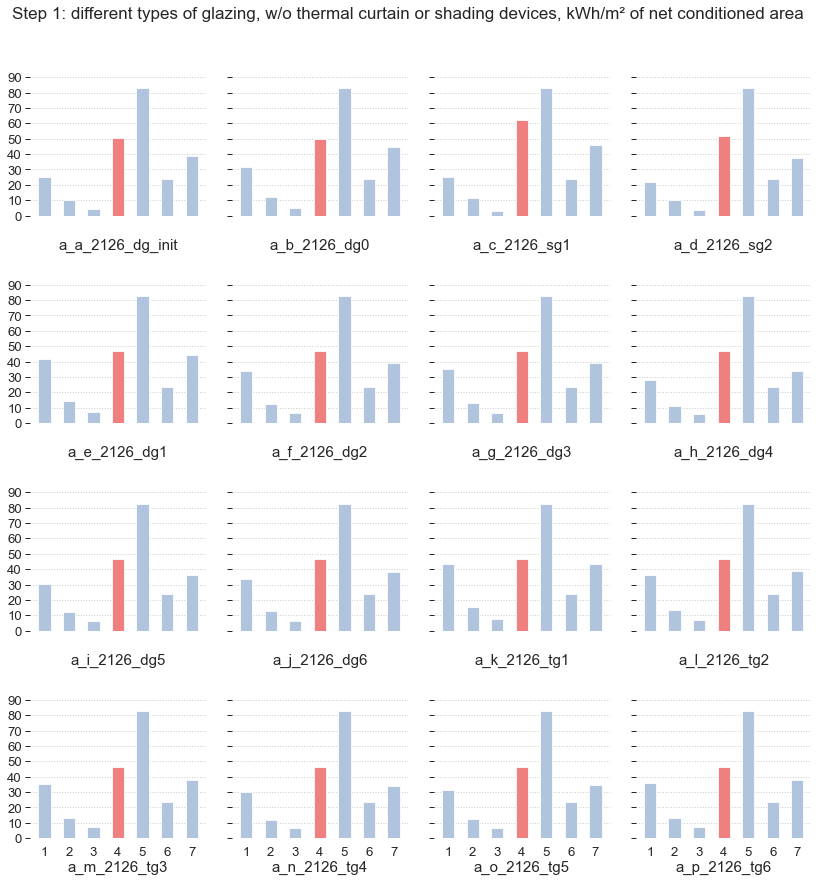

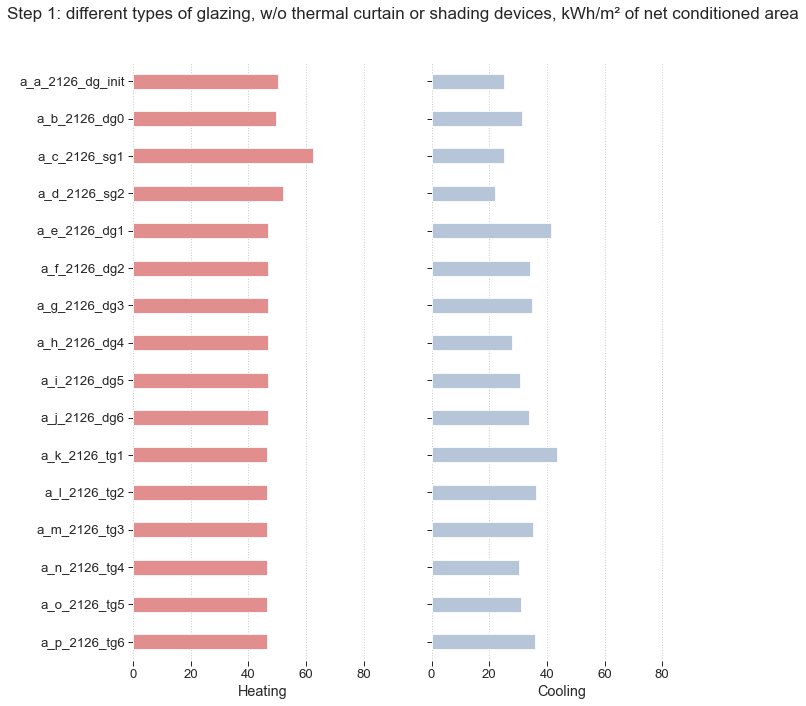

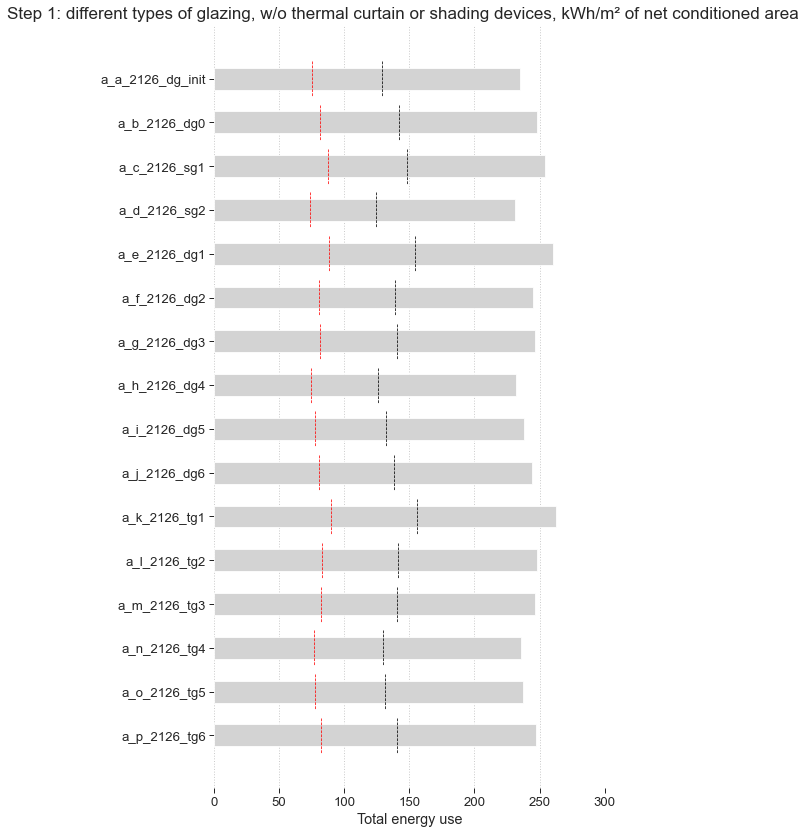

In [142]:
code = "a_"
ylim = 90
title = ("Step 1: different types of glazing," +
         " w/o thermal curtain or shading devices," +
         " kWh/m² of net conditioned area")

# Vertical bar chart with all end uses:
end_use_v_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 2

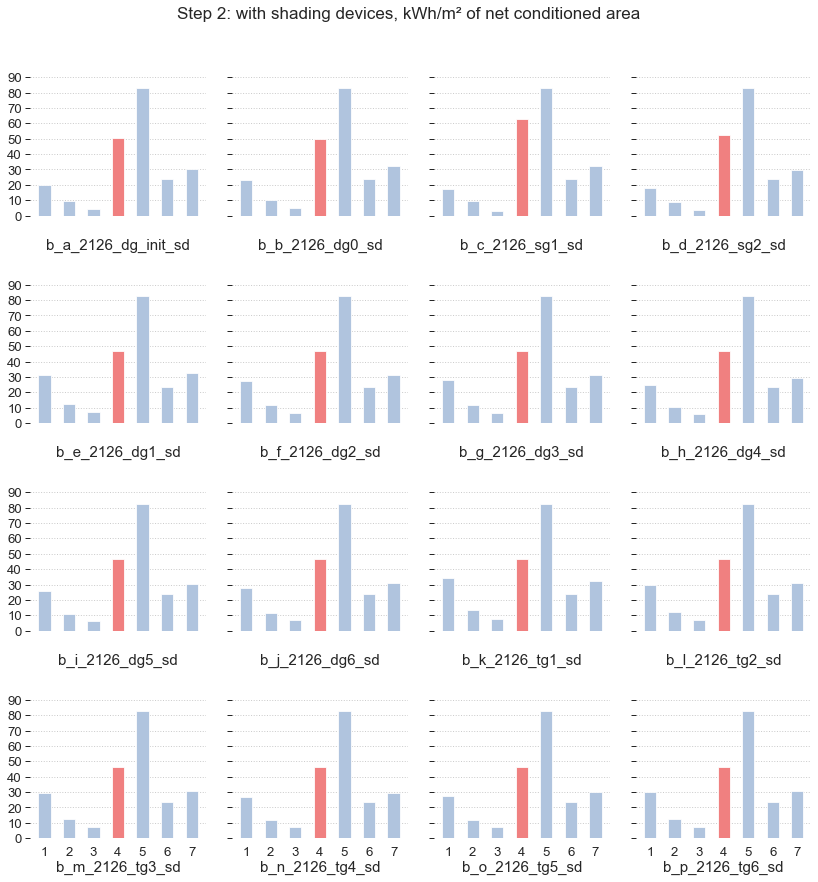

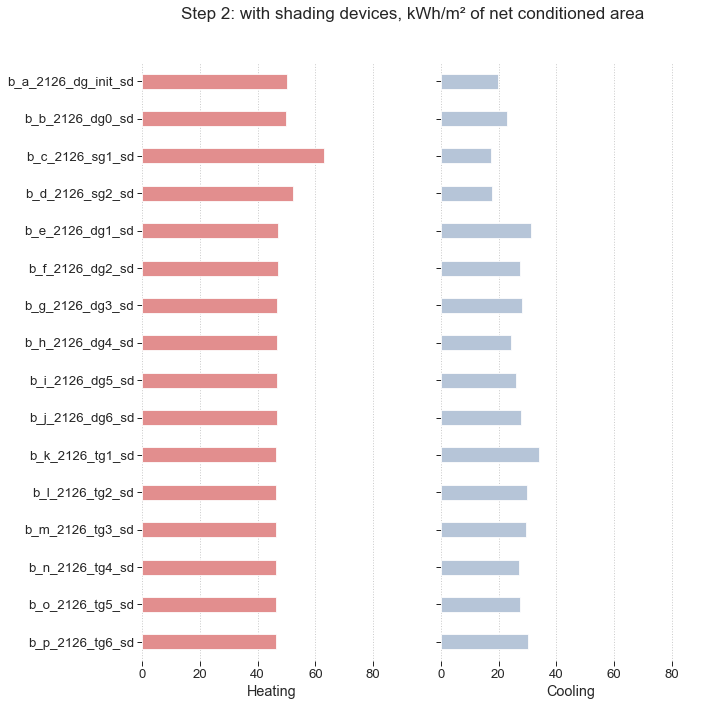

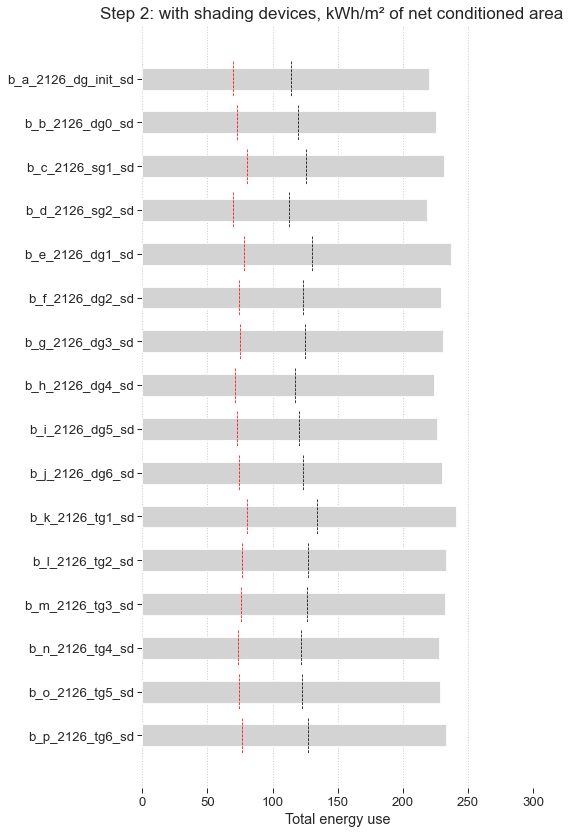

In [143]:
code = "b_"
ylim = 90
title = ("Step 2:" +
         " with shading devices," +
         " kWh/m² of net conditioned area")
# Vertical bar chart with all end uses:
end_use_v_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 3

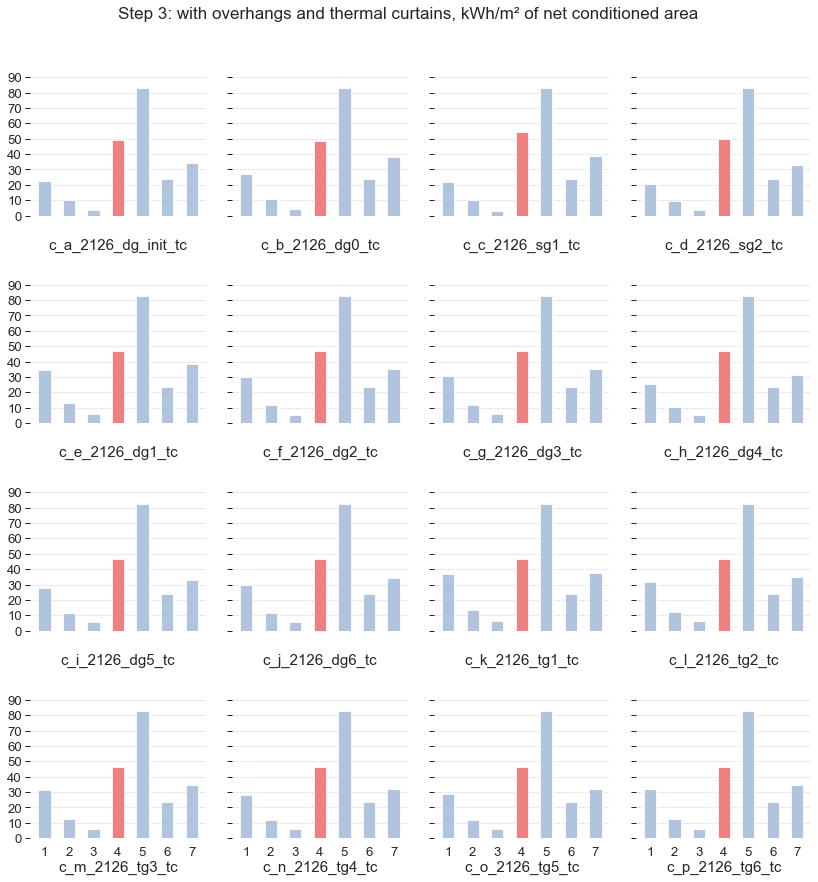

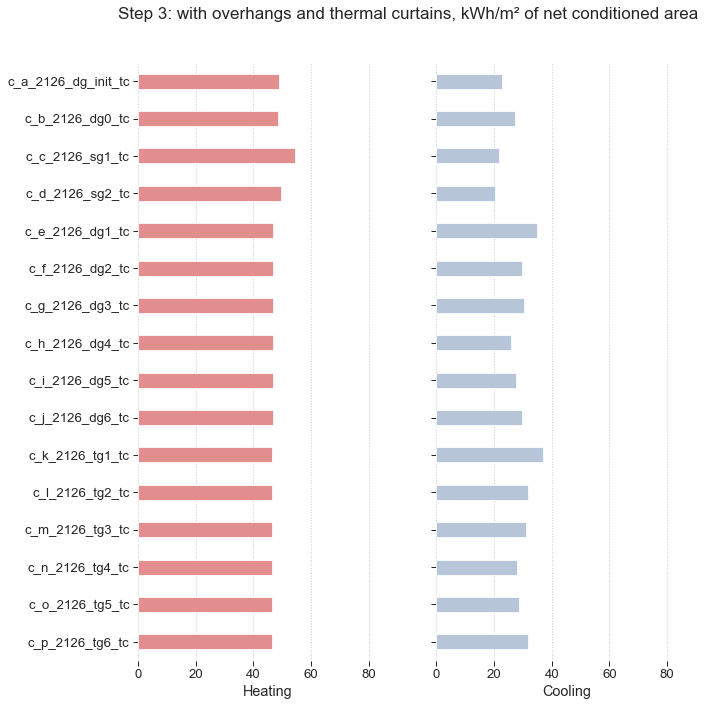

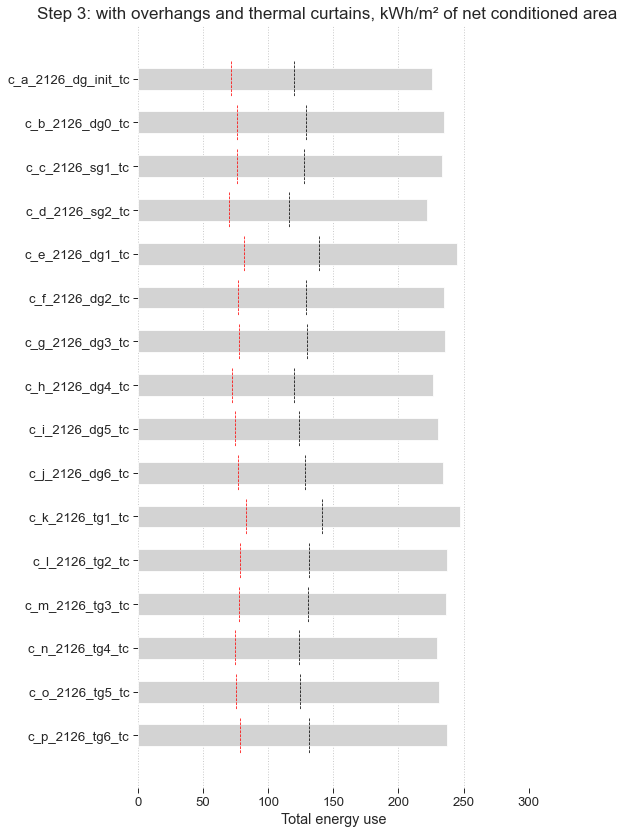

In [144]:
code = "c_"
ylim = 90
title = ("Step 3:" +
         " with overhangs and thermal curtains," +
         " kWh/m² of net conditioned area")
# Vertical bar chart with all end uses:
end_use_v_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 4

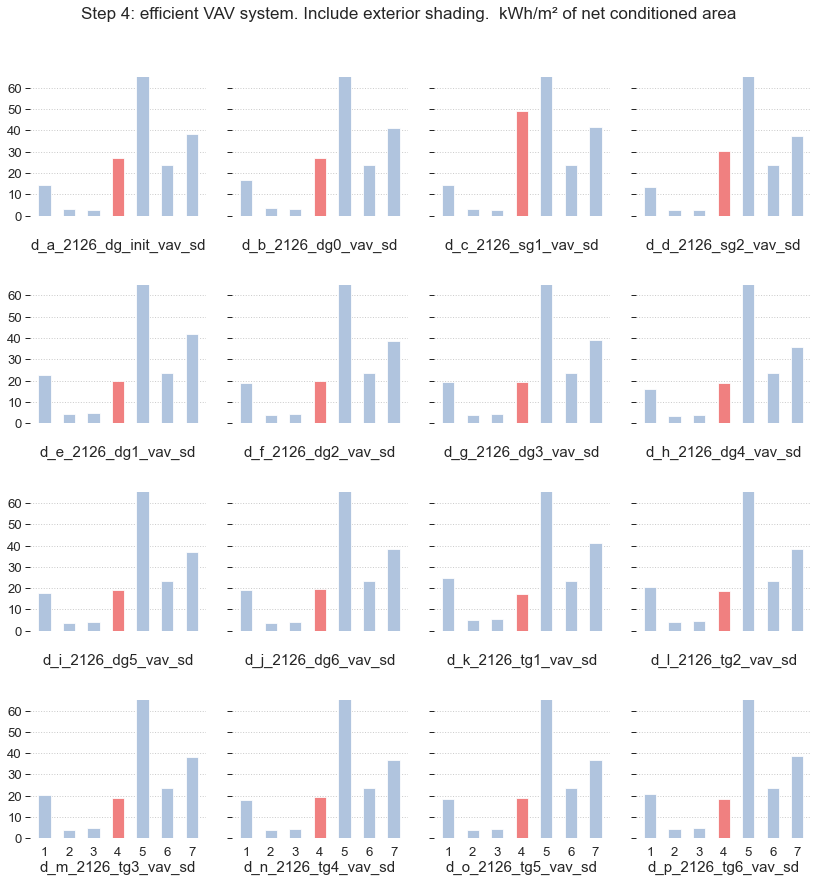

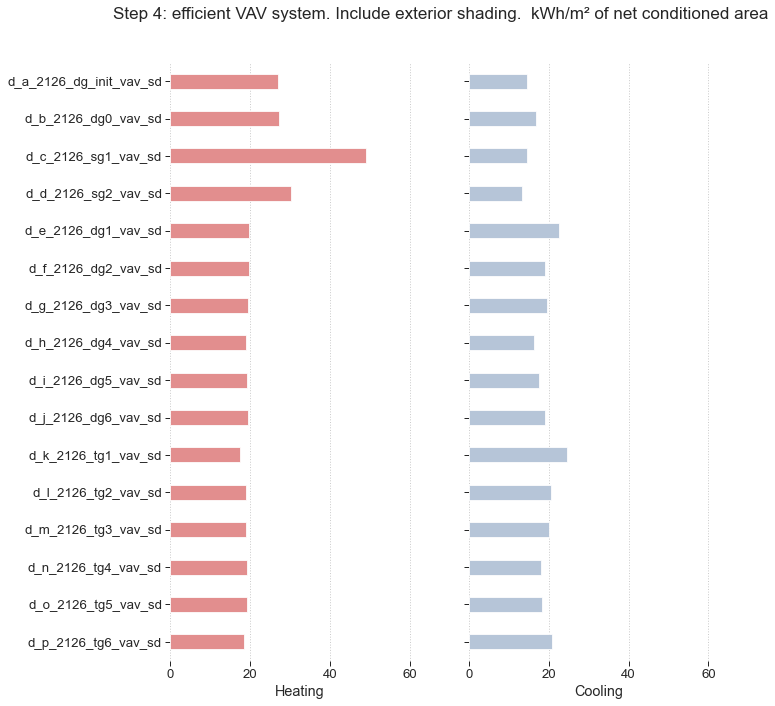

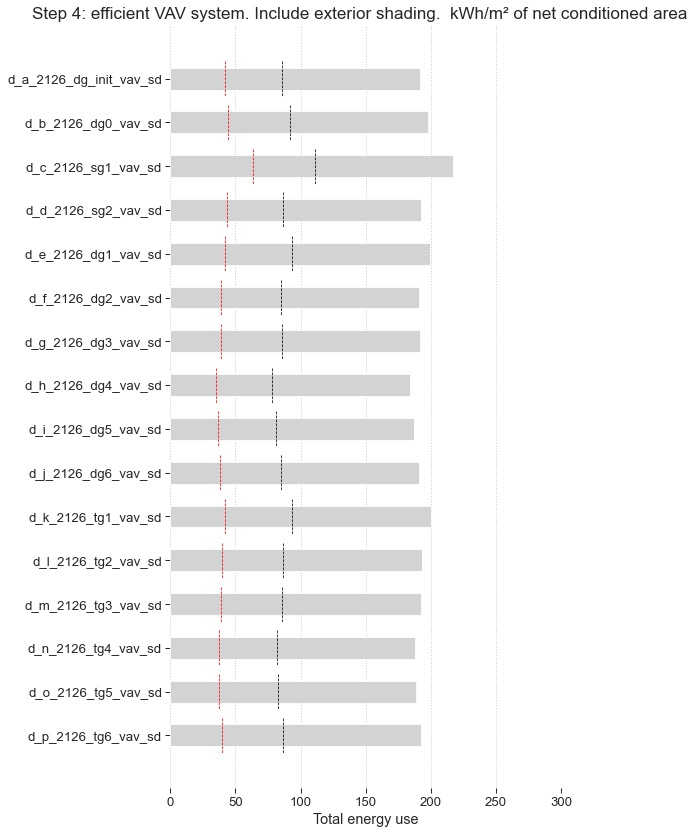

In [148]:
code = "d_"
ylim = 65
title = ("Step 4: efficient VAV system. Include exterior shading. " +
         " kWh/m² of net conditioned area")

# Vertical bar chart with all end uses:
end_use_v_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 8

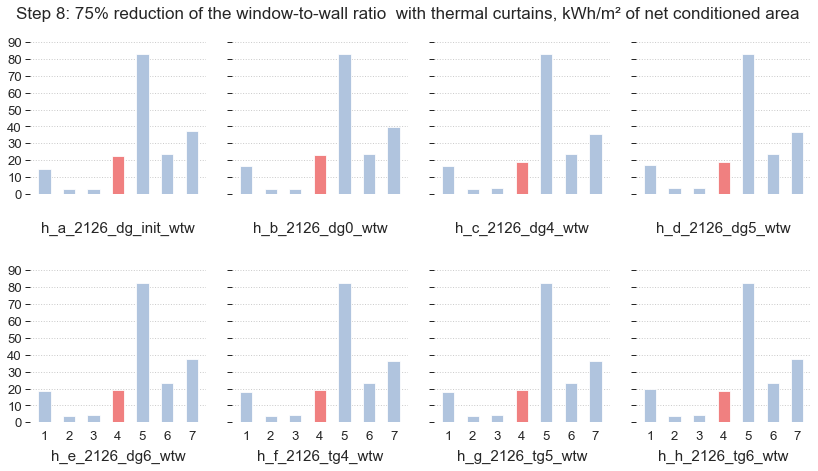

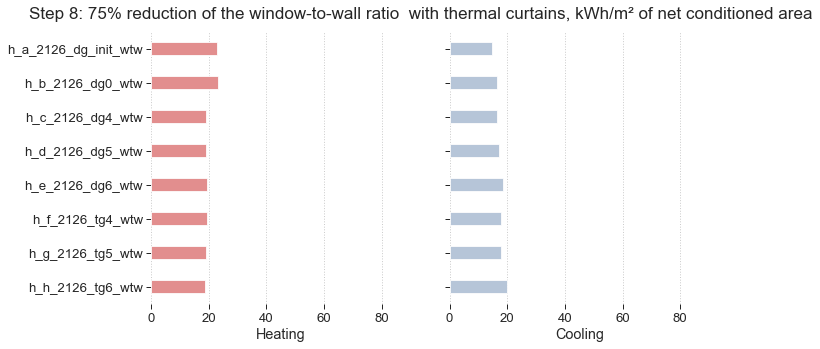

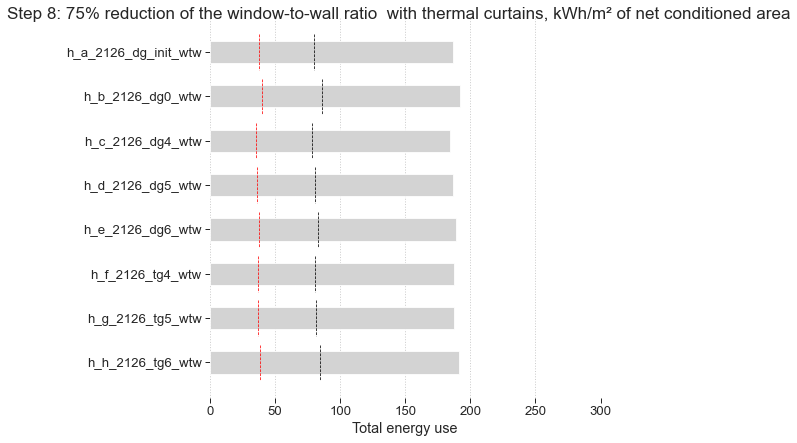

In [147]:
code = "h_"
ylim = 90
title = ("Step 8: 75% reduction of the window-to-wall ratio " +
         " with thermal curtains," +
         " kWh/m² of net conditioned area")

# Vertical bar chart with all end uses:
end_use_v_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

## Heat Gain and Heat Loss through Windows

### Setup to recover useful data

First, the Outdoor Air Drybulb Temperature:

In [153]:
temp_vars = ['Site Outdoor Air Drybulb Temperature']
# Find the output data from the last simulation run:
eplus_sql = EPLusSQL(sql_path='outputs\energyplus\eplusout.sql')
# Define a DataFrame with temperature:
df_temp = eplus_sql.get_hourly_variables(variables_list=temp_vars)

In [154]:
# Clean the DataFrame and mean the temperature per hour:
df_temp.columns = df_temp.columns.droplevel("Units")
df_temp.columns = df_temp.columns.droplevel("KeyValue")

<AxesSubplot:>

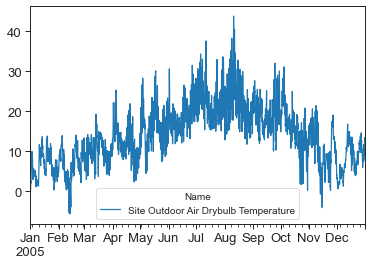

In [155]:
df_temp.plot()

In [156]:
# Define a dataframe with temperature during daytime (8am 8pm), mean per day:
df_temp_d = df_temp.between_time('8:00', '20:00')
df_temp_d = df_temp_d.resample('D').mean()

Define a function to recover the hourly reporting variables from the csv file saved after each simulation run:

In [157]:
def recover_df_hourly(run_code):
    """
    Define a Dataframe from the df_h_run.csv, where hourly reporting 
    variables have been saved for each simulation run  

    Parameters
    ----------
    run_code: code of the simulation run
    df_h_run: a dataframe. followed by a code (e.g. "b_e"), 
        where hourly reporting variables will be saved


    Returns
    -------
    df_h_run

    """

    # Does the csv exist
    # And define the df_h_run:
    if os.path.isfile(f"outputs\steps_dir\df_h_run_"+str(run_code)+".csv"):
        df_h_run = (
            pd.read_csv(f"outputs\steps_dir\df_h_run_"+str(run_code)+".csv",
                        header=[0, 1, 2], index_col=0)
        )

        # Converting the index as date
        df_h_run.index = pd.to_datetime(df_h_run.index)

        print("df_h_run_"+str(run_code)+" created")
    else:
        print("df_h_run does not exist")

    return df_h_run

Define a function to get a dataframe only with heat gain/loss through the windows in the whole building, per day from 8am to 8pm:

In [158]:
def df_heat_window(df_h_run):
    """
    Define a Dataframe from the df_h_run (hourly reporting 
    variables). The resulting df_heat_window has two columns:
    > 'Total Heat Gain, J'
    > 'Total Heat Loss, J'
    These data are the sum for the whole bldg, per day.

    Parameters
    ----------
    df_h_run: a dataframe. followed by a code (e.g. "b_e"), 
        where hourly reporting variables will be saved

    Returns
    -------
    df_heat_window: a DataFrame w/ Windows Total Heat Gain/Loss Energy.

    """

    # Define a DataFrame w/ Windows Total Heat Gain/Loss Energy
    df_window = df_h_run.groupby(level=1, axis=1).sum()
    df_window = df_window.loc[:, df_window.columns.intersection(
        ['Zone Windows Total Heat Gain Energy',
         'Zone Windows Total Heat Loss Energy'])]

    # Consider only heat gain/loss btw 8h and 20h, i.e. daytime
    df_window = df_window.between_time('8:00', '20:00')
    df_window = df_window.resample('D').sum().rename(
        columns={'Zone Windows Total Heat Gain Energy': 'Total Heat Gain, J',
                 'Zone Windows Total Heat Loss Energy': 'Total Heat Loss, J'})

    return df_window

### Analysis of the heat transfers without shadings/curtains

Corresponds to the step1 simulations.

In [159]:
run_code = "a_a"
df_h_run_a_a = recover_df_hourly(run_code)

df_h_run_a_a created


In [160]:
df_window_a_a = df_heat_window(df_h_run_a_a)

<AxesSubplot:xlabel='Count', ylabel='Total Heat Loss, J'>

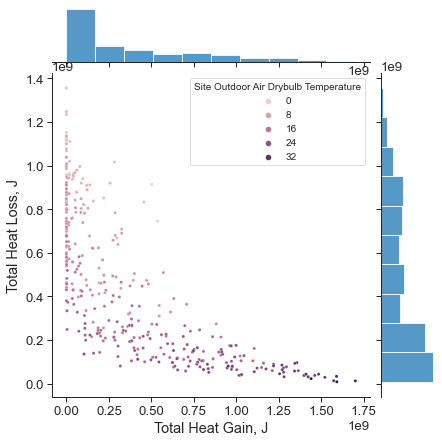

In [161]:
df_to_plot = pd.concat([df_window_a_a, df_temp_d], axis=1)
g = sns.JointGrid()
x, y, z = (df_to_plot["Total Heat Gain, J"],
           df_to_plot["Total Heat Loss, J"],
           df_to_plot["Site Outdoor Air Drybulb Temperature"])
sns.scatterplot(x=x, y=y, hue=z, s=10, ax=g.ax_joint)
sns.histplot(x=x, ax=g.ax_marg_x)
sns.histplot(y=y, ax=g.ax_marg_y)

df_h_run_a_a created
df_h_run_a_b created
df_h_run_a_c created
df_h_run_a_d created
df_h_run_a_e created
df_h_run_a_f created
df_h_run_a_g created
df_h_run_a_h created
df_h_run_a_i created
df_h_run_a_j created
df_h_run_a_k created
df_h_run_a_l created
df_h_run_a_m created
df_h_run_a_n created
df_h_run_a_o created
df_h_run_a_p created


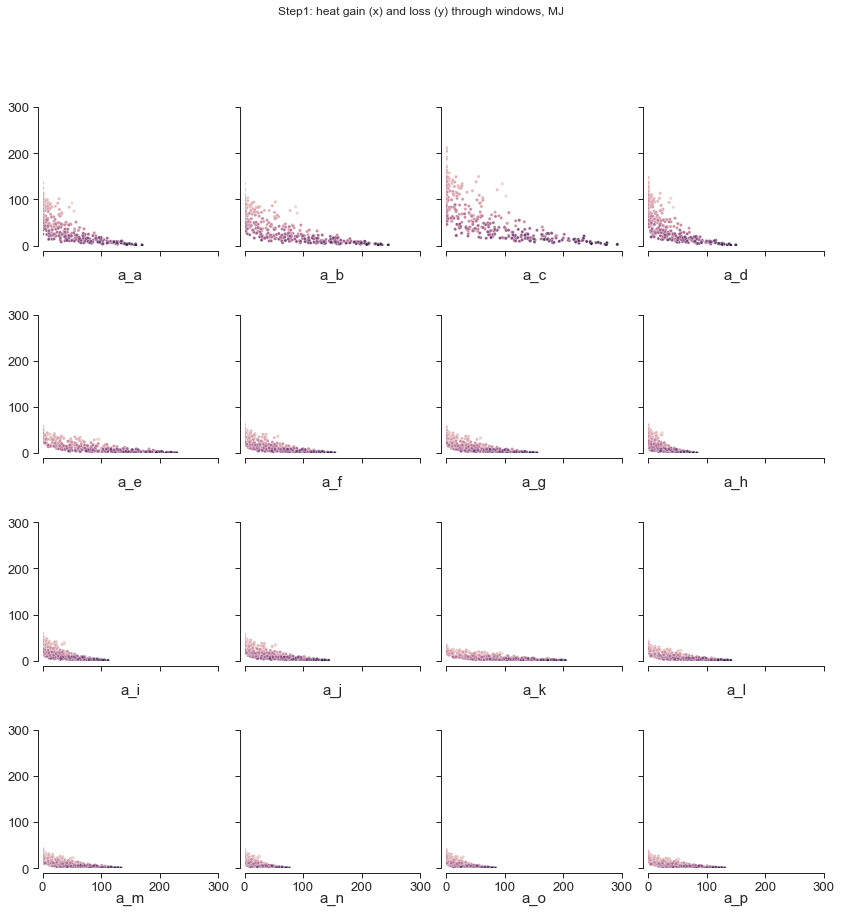

In [162]:
ls_code_to_plot = ["a_a", "a_b", "a_c", "a_d",
                   "a_e", "a_f", "a_g", "a_h",
                   "a_i", "a_j", "a_k", "a_l",
                   "a_m", "a_n", "a_o", "a_p"]

fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for row in range(4):
    for col in range(4):
        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_to_plot[n])
        df_window = df_heat_window(df_h)

        # Concat temperature and heat gain/loss:
        df_to_plot = pd.concat([df_window, df_temp_d], axis=1)

        # Plot with JointGrid:
        x, y, z = (df_to_plot["Total Heat Gain, J"]/10e+6,
                   df_to_plot["Total Heat Loss, J"]/10e+6,
                   df_to_plot["Site Outdoor Air Drybulb Temperature"])
        sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)

        ax.set_title(f"{ls_code_to_plot[n]}", y=-0.35, pad=15)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

ax.set_xlim(0, 300)
plt.xticks(np.arange(0, 301, 100))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step1: heat gain (x) and loss (y) through windows, MJ')
sns.despine(offset=5)
plt.show()

### Analysis of the heat transfers with shadings and high-tech glazing systems

df_h_run_b_a created
df_h_run_b_b created
df_h_run_b_c created
df_h_run_b_d created
df_h_run_b_e created
df_h_run_b_f created
df_h_run_b_g created
df_h_run_b_h created
df_h_run_b_i created
df_h_run_b_j created
df_h_run_b_k created
df_h_run_b_l created
df_h_run_b_m created
df_h_run_b_n created
df_h_run_b_o created
df_h_run_b_p created
df_h_run_h_a created
df_h_run_i_a created
df_h_run_j_a created
df_h_run_j_a created


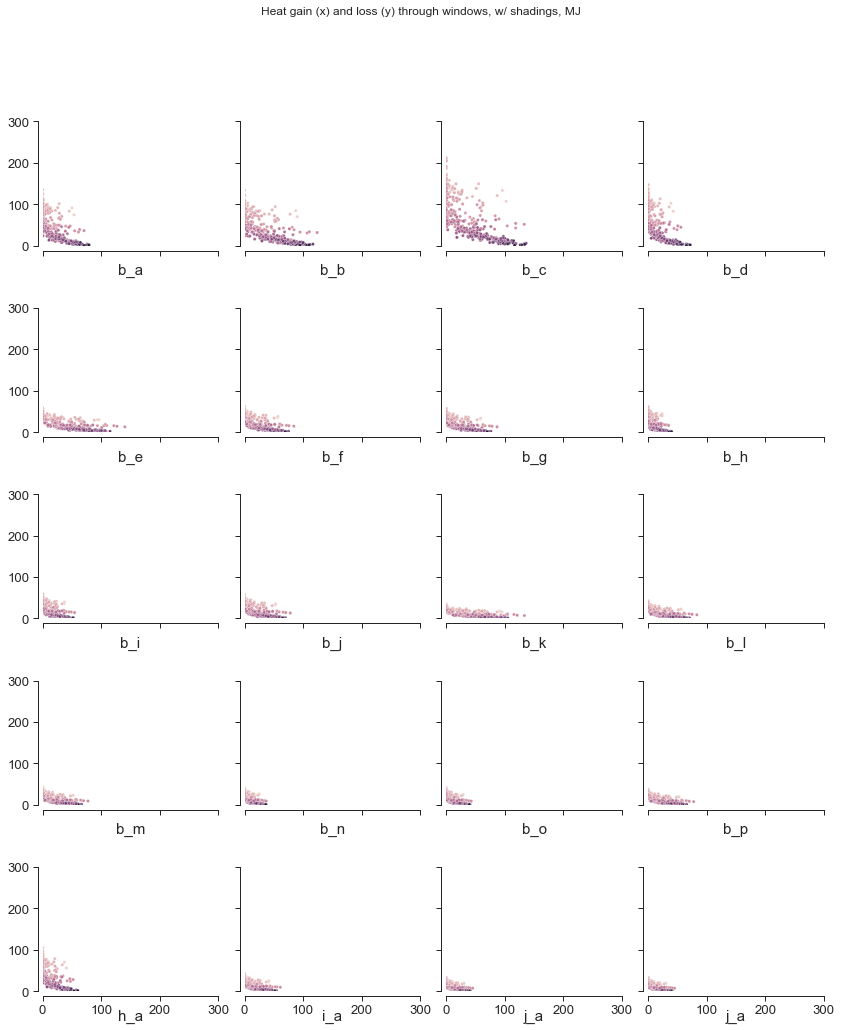

In [163]:
ls_code_to_plot = ["b_a", "b_b", "b_c", "b_d",
                   "b_e", "b_f", "b_g", "b_h",
                   "b_i", "b_j", "b_k", "b_l",
                   "b_m", "b_n", "b_o", "b_p",
                   "h_a", "i_a", "j_a", "j_a"]

fig, axes = plt.subplots(nrows=5, ncols=4,
                         sharex=True, sharey=True,
                         figsize=(14, 16))

n = 0

for row in range(5):
    for col in range(4):
        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_to_plot[n])
        df_window = df_heat_window(df_h)

        # Concat temperature and heat gain/loss:
        df_to_plot = pd.concat([df_window, df_temp_d], axis=1)

        # Plot with JointGrid:
        x, y, z = (df_to_plot["Total Heat Gain, J"]/10e+6,
                   df_to_plot["Total Heat Loss, J"]/10e+6,
                   df_to_plot["Site Outdoor Air Drybulb Temperature"])
        sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)

        ax.set_title(f"{ls_code_to_plot[n]}", y=-0.35, pad=15)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

ax.set_xlim(0, 300)
plt.xticks(np.arange(0, 301, 100))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Heat gain (x) and loss (y) through windows, w/ shadings, MJ')
sns.despine(offset=5)
plt.show()

### Analysis of the heat loss during night time with and without thermal curtains

<font color='red'>DRAFT BELOW / DRAFT BELOW / DRAFT BELOW </font>

# Output Data Analysis 

## Setup

In [ ]:
import datetime
from datetime import timedelta
import time

**If output file as csv:**

A Python fucntion to read a .csv file, do a conversion and change the timestamp:

In [ ]:
def loadsimdata(file, pointname, ConvFactor):
    df = pd.read_csv(file)
    df['desiredpoint'] = df[pointname]*ConvFactor
    df.index = eplustimestamp(df)
    pointdf = df['desiredpoint']
    return pointdf

In [ ]:
# Open the EnergyPlus Output CSV file
df_eplusout = pd.read_csv("outputs\energyplus\eplusout.csv")

**If output file as sql:**

In [ ]:
# Open the EnergyPlus Output SQL file
df_eplusout = pd.read_sql_table(
    "outputs\energyplus\eplusout.sql", 'postgres:///db_name')

In [ ]:
# Open the EnergyPlus Output SQL file
df_eplusout = pd.read_sql("outputs\energyplus\eplusout.sql")

Convert 24:00:00 to 00:00:00 for it to play nice with Pandas:

In [ ]:
# Function to convert timestamps
def eplustimestamp(simdata):
    timestampdict = {}
    for i, row in simdata.T.iteritems():
        timestamp = str(2013) + row['Date/Time']
        try:
            timestampdict[i] = datetime.datetime.strptime(
                timestamp, '%Y %m/%d  %H:%M:%S')
        except ValueError:
            tempts = timestamp.replace(' 24', ' 23')
            timestampdict[i] = datetime.datetime.strptime(
                tempts, '%Y %m/%d  %H:%M:%S')
            timestampdict[i] += timedelta(hours=1)
    timestampseries = pd.Series(timestampdict)
    return timestampseries

In [ ]:
df_eplusout.index = eplustimestamp(df_eplusout)

## Navigate the Output File

Built-in String Query functions to find desired columns:

In [ ]:
ColumnsList = pd.Series(df_eplusout.columns)
ColumnsList.head(100)

In [ ]:
ColumnsList[(ColumnsList.str.endswith(
    "Zone Mean Air Temperature [C](Hourly)"))]

In [ ]:
# Select all columns for Mean Air Temperature:
ZoneTempPointList = list(
    ColumnsList[(ColumnsList.str.endswith("Zone Mean Air Temperature [C](Hourly)"))])
ZoneTempPointList

In [ ]:
BasementZoneTemp = list(
    ColumnsList[
        (ColumnsList.str.endswith("Zone Mean Air Temperature [C](Hourly)"))
        & (ColumnsList.str.contains("BASEMENT"))])

GroundFloorZoneTemp = list(
    ColumnsList[
        (ColumnsList.str.endswith("Zone Mean Air Temperature [C](Hourly)"))
        & (ColumnsList.str.contains("GROUNDFLOOR"))])

MidZoneTemp = list(
    ColumnsList[
        (ColumnsList.str.endswith("Zone Mean Air Temperature [C](Hourly)"))
        & (ColumnsList.str.contains("MID"))])

TopZoneTemp = list(
    ColumnsList[
        (ColumnsList.str.endswith("Zone Mean Air Temperature [C](Hourly)"))
        & (ColumnsList.str.contains("TOP"))])

In [ ]:
# Calculate mean air temperature per total office area per floor:
for zone in ["GROUNDFLOOR", "MID", "TOP"]:
    df_eplusout[f"{zone} All Offices Mean Air Temp [C](Hourly)"] = df_eplusout[
        ColumnsList[
            (ColumnsList.str.endswith("Zone Mean Air Temperature [C](Hourly)"))
            & (ColumnsList.str.contains(f"{zone}"))
            & ((ColumnsList.str.contains("HALL"))
               | (ColumnsList.str.contains("OFFICES")))]].mean(axis=1)
    ZoneTempPointList.append(f"{zone} All Offices Mean Air Temp [C](Hourly)")

In [ ]:
ZoneTempPointList

In [ ]:
df_zonetemp = df_eplusout[ZoneTempPointList]

In [ ]:
df_zonetemp.info()

## Visualisation

Mean temperature pe zone:

In [ ]:
df_zonetemp.plot(figsize=(25, 15))

In [ ]:
df_zonetemp[GroundFloorZoneTemp].plot(figsize=(25, 10))

In [ ]:
df_zonetemp['GROUNDFLOOR All Offices Mean Air Temp [C](Hourly)'].plot(
    figsize=(25, 10))

In [ ]:
df_zonetemp['TOP All Offices Mean Air Temp [C](Hourly)'].plot(figsize=(25, 10))

In [ ]:
df_zonetemp['TOP All Offices Mean Air Temp [C](Hourly)'].truncate(
    before='2013-02-13', after='2013-02-20').plot(figsize=(25, 10))

## Heatmaps